In [145]:
import numpy as np
import pandas as pd
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import random
import pickle
import json
import math

from sklearn.model_selection import train_test_split

fig_dpi = 500

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Neural Network Training


## Load Dataset

Read CSVs dumped from MatLab and parse into Pandas DataFrames

In [7]:
data = pd.read_csv('features.csv', header=None).T
data.columns = ['Clump thickness', 'Uniformity of cell size', 'Uniformity of cell shape', 'Marginal adhesion', 'Single epithelial cell size', 'Bare nuclei', 'Bland chomatin', 'Normal nucleoli', 'Mitoses']
labels = pd.read_csv('targets.csv', header=None).T
labels.columns = ['Benign', 'Malignant']
data.describe()

,Clump thickness,Uniformity of cell size,Uniformity of cell shape,Marginal adhesion,Single epithelial cell size,Bare nuclei,Bland chomatin,Normal nucleoli,Mitoses
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,0.441774,0.313448,0.320744,0.280687,0.321602,0.354363,0.343777,0.286695,0.158941
std,0.281574,0.305146,0.297191,0.285538,0.221430,0.360186,0.243836,0.305363,0.171508
min,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
25%,0.200000,0.100000,0.100000,0.100000,0.200000,0.100000,0.200000,0.100000,0.100000
50%,0.400000,0.100000,0.100000,0.100000,0.200000,0.100000,0.300000,0.100000,0.100000
75%,0.600000,0.500000,0.500000,0.400000,0.400000,0.500000,0.500000,0.400000,0.100000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [3]:
labels.head()

,Benign,Malignant
0,1,0
1,1,0
2,1,0
3,0,1
4,1,0


### Explore Dataset

The classes are uneven in their occurences, stratify when splitting later on

In [5]:
labels.astype(bool).sum(axis=0)

Benign       458
Malignant    241
dtype: int64

## Split Dataset

Using a 50/50 split

In [8]:
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.5, stratify=labels)

## Generate & Retrieve Model

Get a shallow model with a single hidden layer of varying nodes

In [9]:
def get_model(hidden_nodes=9, activation=lambda: 'sigmoid', weight_init=lambda: 'glorot_uniform'):
    layers = [tf.keras.layers.InputLayer(input_shape=(9,)), 
              tf.keras.layers.Dense(hidden_nodes, activation=activation(), kernel_initializer=weight_init()), 
              tf.keras.layers.Dense(2, activation='softmax', kernel_initializer=weight_init())]

    model = tf.keras.models.Sequential(layers)
    return model

# Example Training

## Define Model

Variable number of hidden nodes. All using 9D outputs except the last layer which is 2D for binary classification

In [6]:
model = get_model(9)
model.compile('sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 9)                 90        
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 20        
Total params: 110
Trainable params: 110
Non-trainable params: 0
_________________________________________________________________


## Train Model

Example 10 epochs

In [7]:
model.fit(data_train, labels_train, epochs=5)

Epoch 1/5
11/11 [==============================] - 1s 2ms/step - loss: 0.7427 - accuracy: 0.6265
Epoch 2/5
11/11 [==============================] - 0s 2ms/step - loss: 0.6953 - accuracy: 0.6543
Epoch 3/5
11/11 [==============================] - 0s 2ms/step - loss: 0.7317 - accuracy: 0.6061
Epoch 4/5
11/11 [==============================] - 0s 3ms/step - loss: 0.6081 - accuracy: 0.7133
Epoch 5/5
11/11 [==============================] - 0s 2ms/step - loss: 0.6659 - accuracy: 0.6554


In [10]:
model.metrics_names

['loss', 'accuracy']

In [11]:
model.metrics[1].result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.6561605>

# Experiment 1

The below function runs an iteration of layer/epoch investigations.
Returns the amount of layers/epochs used as well as the results and the model.

Using cancer dataset (as in E2) and ‘trainscg’ or an optimiser of your choice, vary nodes and epochs (that is using early stopping for epochs) over suitable range, to find optimal choice in terms of classification test error rate of node/epochs for 50/50% random train/test split (no validation set). It is suggested that you initially try epochs = [ 1 2 4 8 16 32 64], nodes = [2 8 32], so there would be 21 node/epoch combinations. 

(Hint1: from the ‘advanced script’in E2, nodes can be changed to xx, with hiddenLayerSize = xx; and epochs changed to xx by addingnet. trainParam.epochs = xx; placed afternet = patternnet(hiddenLayerSize, trainFcn); --see ‘trainscg’ help documentation for changing epochs). 

Repeat each of the 21 node/epoch combinations at least thirty times, with different 50/50 split and take average and report classification error rate and standard deviation (std). Graph classification train and test error rate and std as node-epoch changes, that is plot error rate vs epochs for different number of nodes. Report the optimal value for test error rate and associated node/epoch values. 

(Hint2: as epochs increases you can expect the test error rate to reach a minimum and then start increasing, you may need to set the stopping criteria to achieve the desired number of epochs – Hint 3: to find classification error rates for train and test set, you need to check the code from E2, to determine how you may obtain the train and test set patterns)


In [12]:
hidden_nodes = [2, 8, 16, 24, 32]
epochs = [1, 2, 4, 8, 16, 32, 64, 100, 150, 200]

def evaluate_parameters(hidden_nodes=hidden_nodes, 
                        epochs=epochs, 
                        batch_size=128,
                        optimizer=lambda: 'sgd',
                        loss=lambda: 'categorical_crossentropy',
                        metrics=['accuracy'],
                        callbacks=None,
                        validation_split=None,

                        verbose=0,
                        print_params=True,
                        return_model=True,
                        
                        dtrain=data_train,
                        dtest=data_test,
                        ltrain=labels_train,
                        ltest=labels_test):
    for idx1, hn in enumerate(hidden_nodes):
        for idx2, e in enumerate(epochs):
            if print_params:
                print(f"Nodes: {hn}, Epochs: {e}")

            model = get_model(hn)
            model.compile(
                optimizer=optimizer(),
                loss=loss(),
                metrics=metrics
                )
            
            response = {"nodes": hn, 
                        "epochs": e,
                        "history": model.fit(dtrain, 
                                             ltrain, 
                                             epochs=e, 
                                             verbose=verbose,
                                             
                                             callbacks=callbacks,
                                             validation_split=validation_split).history,
                        "results": model.evaluate(dtest, 
                                                 ltest, 
                                                 batch_size=batch_size, 
                                                 verbose=verbose),
                        "optimizer": model.optimizer.get_config(),
                        "loss": model.loss,
                        "model_config": json.loads(model.to_json())
                       }

            if return_model:
                response["model"] = model

            yield response

## Single Iteration
Run a single iteration of epoch/layer investigations

In [52]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience = 5)
single_results = list(
    evaluate_parameters(return_model=False, validation_split=0.2
                        , optimizer = lambda: tf.keras.optimizers.SGD(learning_rate=0.5, momentum=0.5)
                        # ,callbacks=[es]
                        )
    )

Nodes: 2, Epochs: 1
Nodes: 2, Epochs: 2
Nodes: 2, Epochs: 4
Nodes: 2, Epochs: 8
Nodes: 2, Epochs: 16
Nodes: 2, Epochs: 32
Nodes: 2, Epochs: 64
Nodes: 2, Epochs: 100
Nodes: 2, Epochs: 150
Nodes: 2, Epochs: 200
Nodes: 8, Epochs: 1
Nodes: 8, Epochs: 2
Nodes: 8, Epochs: 4
Nodes: 8, Epochs: 8
Nodes: 8, Epochs: 16
Nodes: 8, Epochs: 32
Nodes: 8, Epochs: 64
Nodes: 8, Epochs: 100
Nodes: 8, Epochs: 150
Nodes: 8, Epochs: 200
Nodes: 16, Epochs: 1
Nodes: 16, Epochs: 2
Nodes: 16, Epochs: 4
Nodes: 16, Epochs: 8
Nodes: 16, Epochs: 16
Nodes: 16, Epochs: 32
Nodes: 16, Epochs: 64
Nodes: 16, Epochs: 100
Nodes: 16, Epochs: 150
Nodes: 16, Epochs: 200
Nodes: 24, Epochs: 1
Nodes: 24, Epochs: 2
Nodes: 24, Epochs: 4
Nodes: 24, Epochs: 8
Nodes: 24, Epochs: 16
Nodes: 24, Epochs: 32
Nodes: 24, Epochs: 64
Nodes: 24, Epochs: 100
Nodes: 24, Epochs: 150
Nodes: 24, Epochs: 200
Nodes: 32, Epochs: 1
Nodes: 32, Epochs: 2
Nodes: 32, Epochs: 4
Nodes: 32, Epochs: 8
Nodes: 32, Epochs: 16
Nodes: 32, Epochs: 32
Nodes: 32, Epoch

### Train/Test Curves

For a single test from the set

Nodes: 2, Epochs: 100


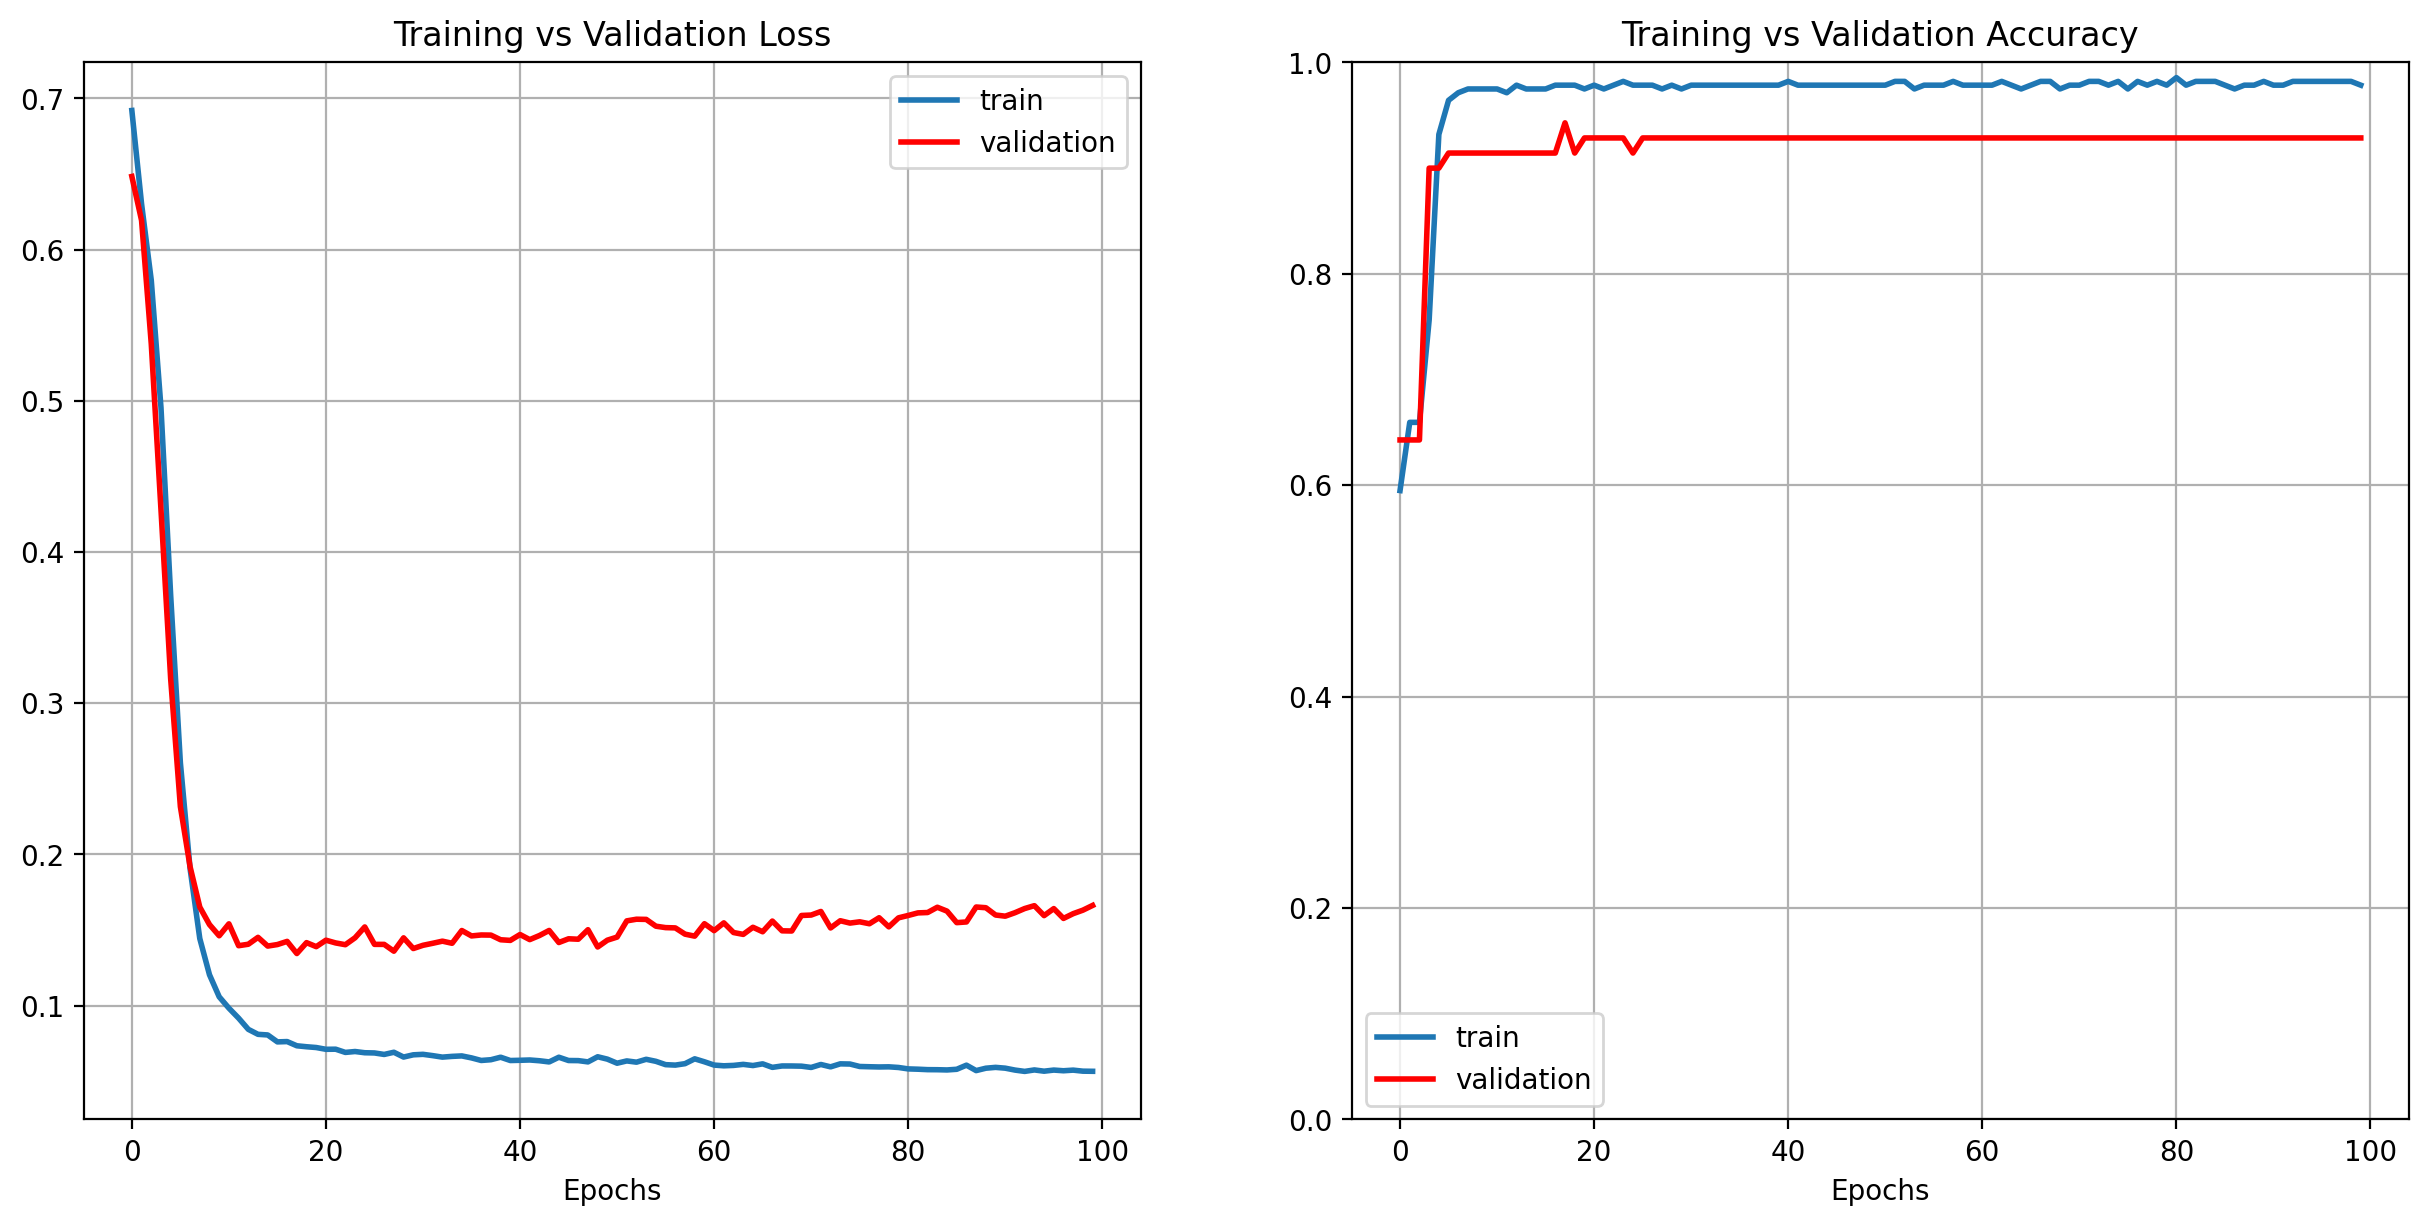

In [25]:
single_result = random.choice([i for i in single_results if i["epochs"] > 80])
single_history = single_result["history"]

fig, axes = plt.subplots(1, 2, figsize=(15,7))
fig.set_dpi(fig_dpi)

ax = axes[0]
ax.set_title("Training vs Validation Loss")
ax.plot(single_history['loss'], label="train", lw=2)
ax.plot(single_history['val_loss'], label="validation", lw=2, c=(1,0,0))
ax.set_xlabel("Epochs")
ax.grid()
ax.legend()

ax = axes[1]
ax.set_title("Training vs Validation Accuracy")
ax.plot(single_history['accuracy'], label="train", lw=2)
ax.plot(single_history['val_accuracy'], label="validation", lw=2, c=(1,0,0))
ax.set_xlabel("Epochs")
ax.set_ylim(0, 1)
ax.grid()
ax.legend()

print(f"Nodes: {single_result['nodes']}, Epochs: {single_result['epochs']}")
# plt.tight_layout()
plt.savefig('fig.png')
plt.show()

### Accuracy Surface

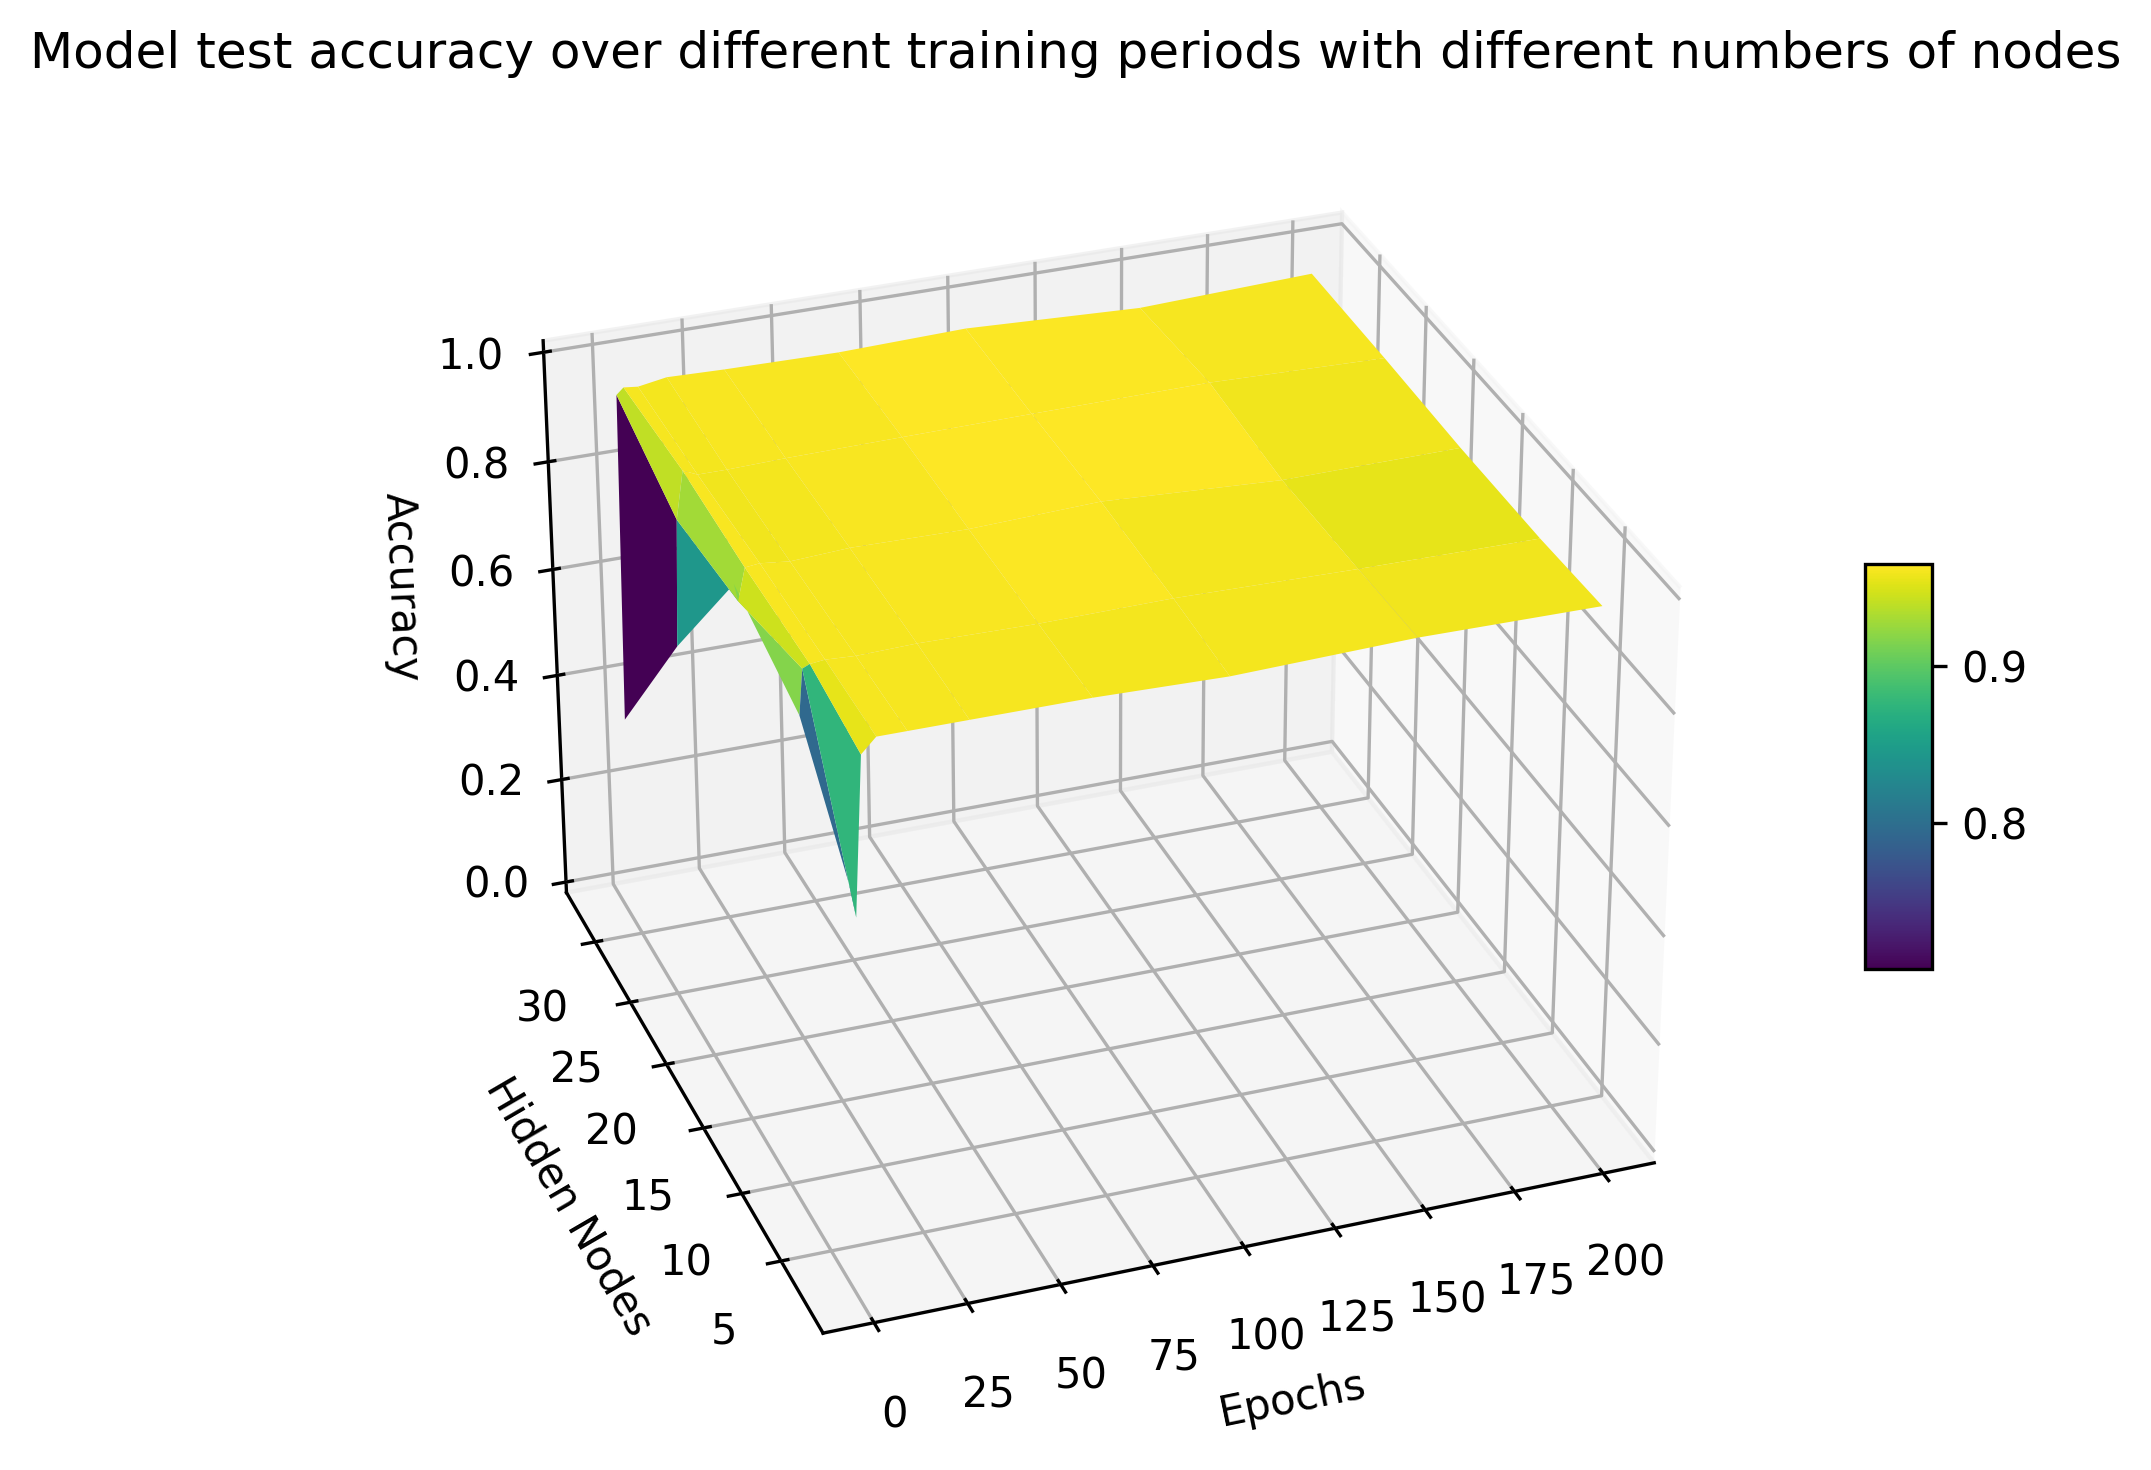

In [56]:
X, Y = np.meshgrid(epochs, hidden_nodes)

shaped_result = np.reshape([r["results"][1] for r in single_results], 
                           (len(hidden_nodes), len(epochs)))

fig = plt.figure(figsize=(8, 5))
fig.set_dpi(fig_dpi)
ax = plt.axes(projection='3d')

surf = ax.plot_surface(X, Y, shaped_result, cmap='viridis')
ax.set_title('Model test accuracy over different training periods with different numbers of nodes')
ax.set_xlabel('Epochs')
ax.set_ylabel('Hidden Nodes')
ax.set_zlabel('Accuracy')
ax.view_init(30, -110)
ax.set_zlim([0, 1])
fig.colorbar(surf, shrink=0.3, aspect=6)

plt.tight_layout()
plt.savefig('fig.png')
plt.show()

### Error Rate Curves

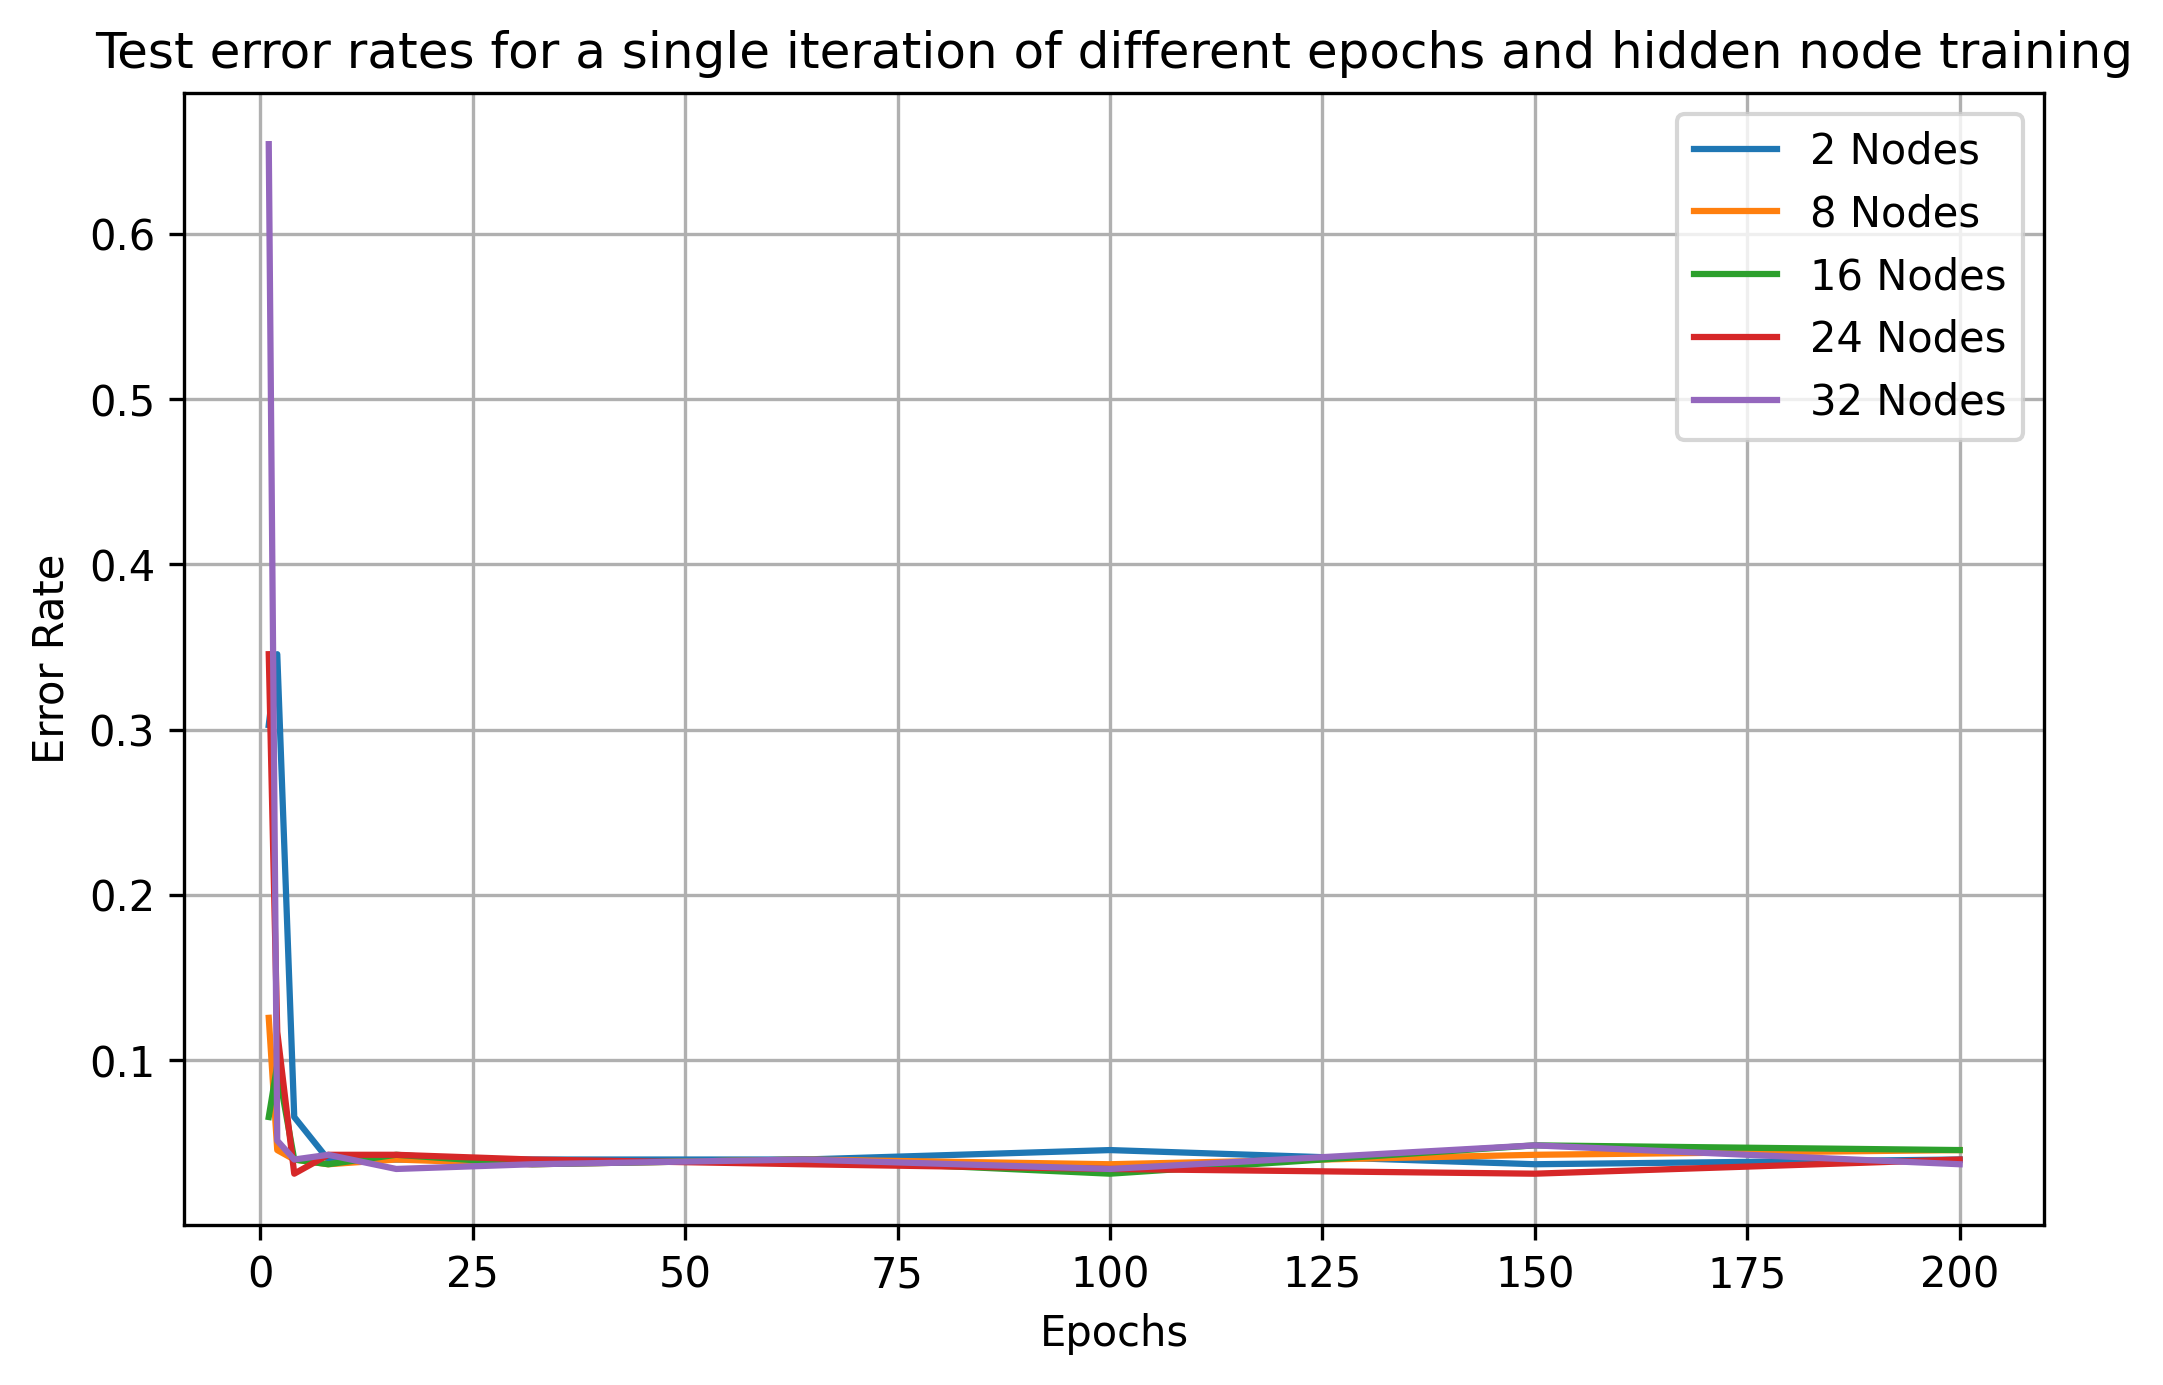

In [57]:
fig = plt.figure(figsize=(8, 5))
fig.set_dpi(fig_dpi)

for layer in hidden_nodes:
    plt.plot(epochs, 
             1 - np.array([i["results"][1] 
                  for i in single_results 
                  if i["nodes"] == layer]), 
             label=f'{layer} Nodes')

plt.legend()
plt.grid()
plt.title("Test error rates for a single iteration of different epochs and hidden node training")
plt.xlabel("Epochs")
plt.ylabel("Error Rate")

plt.savefig('fig.png')
plt.show()

## Multiple Iterations

Run multiple iterations of the epoch/layer investigations and average

## CSV Results

| test | learning rate | momentum | batch size | hidden nodes | epochs |
| --- | --- | --- | --- | --- | --- |
|1|0.01|0|128|2, 8, 12, 16, 24, 32, 64, 128, 256|1, 2, 4, 8, 16, 32, 64, 100, 150, 200|
|2|0.5|0.1|128|2, 8, 12, 16, 24, 32, 64, 128|1, 2, 4, 8, 16, 32, 64, 100|
|3|0.2|0.05|128|2, 8, 12, 16, 24, 32, 64, 128|1, 2, 4, 8, 16, 32, 64, 100|
|4|0.08|0.04|128|2, 8, 12, 16, 24, 32, 64, 128|1, 2, 4, 8, 16, 32, 64, 100|
|5|0.08|0|128|2, 8, 12, 16, 24, 32, 64, 128|1, 2, 4, 8, 16, 32, 64, 100|
|6|0.06|0|128|1, 2, 3, 4, 5, 6, 7, 8|1, 2, 4, 8, 16, 32, 64, 100|
|7|0.06|0|35|2, 8, 12, 16, 24, 32, 64, 128|1, 2, 4, 8, 16, 32, 64, 100|

## Pickle Results

| test | learning rate | momentum | batch size | hidden nodes | epochs |
| --- | --- | --- | --- | --- | --- |
|1|0.01|0|128|2, 8, 12, 16, 24, 32, 64, 128, 256|1, 2, 4, 8, 16, 32, 64, 100, 150, 200|
|2|0.5|0.1|128|2, 8, 12, 16, 24, 32, 64, 128|1, 2, 4, 8, 16, 32, 64, 100|
|3|1|0.3|20|2, 8, 12, 16, 24, 32, 64, 128|1, 2, 4, 8, 16, 32, 64, 100|
|4|0.6|0.1|20|2, 8, 16, 24, 32|1, 2, 4, 8, 16, 32, 64, 100, 150, 200|
|5|0.05|0.01|20|2, 8, 16, 24, 32|1, 2, 4, 8, 16, 32, 64, 100, 150, 200|
|6|1.5|0.5|20|2, 8, 16, 24, 32|1, 2, 4, 8, 16, 32, 64, 100, 150, 200|

In [30]:
multi_param_results = list()
multi_iterations = 30
for i in range(multi_iterations):
    print(f"Iteration {i+1}/{multi_iterations}")
    data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.5, stratify=labels)
    multi_param_results.append(list(evaluate_parameters(dtrain=data_train, 
                                                  dtest=data_test, 
                                                  ltrain=labels_train, 
                                                  ltest=labels_test,
                                                  optimizer=lambda: tf.keras.optimizers.SGD(learning_rate=1.5, momentum=0.5),
                                                  return_model=False,
                                                  print_params=False,
                                                  batch_size=20)))

Iteration 1/30
Iteration 2/30
Iteration 3/30
Iteration 4/30
Iteration 5/30
Iteration 6/30
Iteration 7/30
Iteration 8/30
Iteration 9/30
Iteration 10/30
Iteration 11/30
Iteration 12/30
Iteration 13/30
Iteration 14/30
Iteration 15/30
Iteration 16/30
Iteration 17/30
Iteration 18/30
Iteration 19/30
Iteration 20/30
Iteration 21/30
Iteration 22/30
Iteration 23/30
Iteration 24/30
Iteration 25/30
Iteration 26/30
Iteration 27/30
Iteration 28/30
Iteration 29/30
Iteration 30/30


### Accuracy Tensor

Create a tensor for holding the accuracy results

(Iterations x [Test/Train] x Number of nodes x Number of epochs)

In [173]:
multi_param_epochs = sorted(list({i["epochs"] for i in multi_param_results[0]}))
multi_param_nodes = sorted(list({i["nodes"] for i in multi_param_results[0]}))
multi_param_iter = len(multi_param_results)

accuracy_tensor = np.zeros((multi_param_iter, 2, len(multi_param_nodes), len(multi_param_epochs)))
for iter_idx, iteration in enumerate(multi_param_results):
    for single_test in iteration:
        accuracy_tensor[iter_idx, 
                        0,
                        multi_param_nodes.index(single_test['nodes']), 
                        multi_param_epochs.index(single_test['epochs'])] = single_test["results"][1]
        
        accuracy_tensor[iter_idx,
                        1,
                        multi_param_nodes.index(single_test['nodes']), 
                        multi_param_epochs.index(single_test['epochs'])] = single_test["history"]["accuracy"][-1]
        
mean_param_accuracy = np.mean(accuracy_tensor, axis=0)
std_param_accuracy = np.std(accuracy_tensor, axis=0)

print(f'{multi_param_iter} Tests')
print(f'Nodes: {multi_param_nodes}')
print(f'Epochs: {multi_param_epochs}')
print()
print(f'Loss: {multi_param_results[0][0]["loss"]}')
print(f'LR: {multi_param_results[0][0]["optimizer"]["learning_rate"]}')
print(f'Momentum: {multi_param_results[0][0]["optimizer"]["momentum"]}')

30 Tests
Nodes: [2, 8, 16, 24, 32]
Epochs: [1, 2, 4, 8, 16, 32, 64, 100, 150, 200]

Loss: categorical_crossentropy
LR: 0.05000000074505806
Momentum: 0.009999999776482582


#### Export/Import Test Sets

Export mean and standard deviations for retrieval and visualisation 

In [31]:
pickle.dump(multi_param_results, open("result.p", "wb"))

In [172]:
exp1_testname = 'exp1-test5'
multi_param_results = pickle.load(open(f"results/{exp1_testname}.p", "rb"))

### Best Results

In [141]:
best_param_accuracy_idx = np.unravel_index(np.argmax(mean_param_accuracy[0, :, :]), mean_param_accuracy.shape)
best_param_accuracy = mean_param_accuracy[best_param_accuracy_idx]
best_param_accuracy_nodes = multi_param_nodes[best_param_accuracy_idx[1]]
best_param_accuracy_epochs = multi_param_epochs[best_param_accuracy_idx[2]]

print(f'Nodes: {best_param_accuracy_nodes}, Epochs: {best_param_accuracy_epochs}, {np.round(best_param_accuracy * 100, 1)}% Accurate')

Nodes: 24, Epochs: 8, 96.9% Accurate


### Test Accuracy Surface

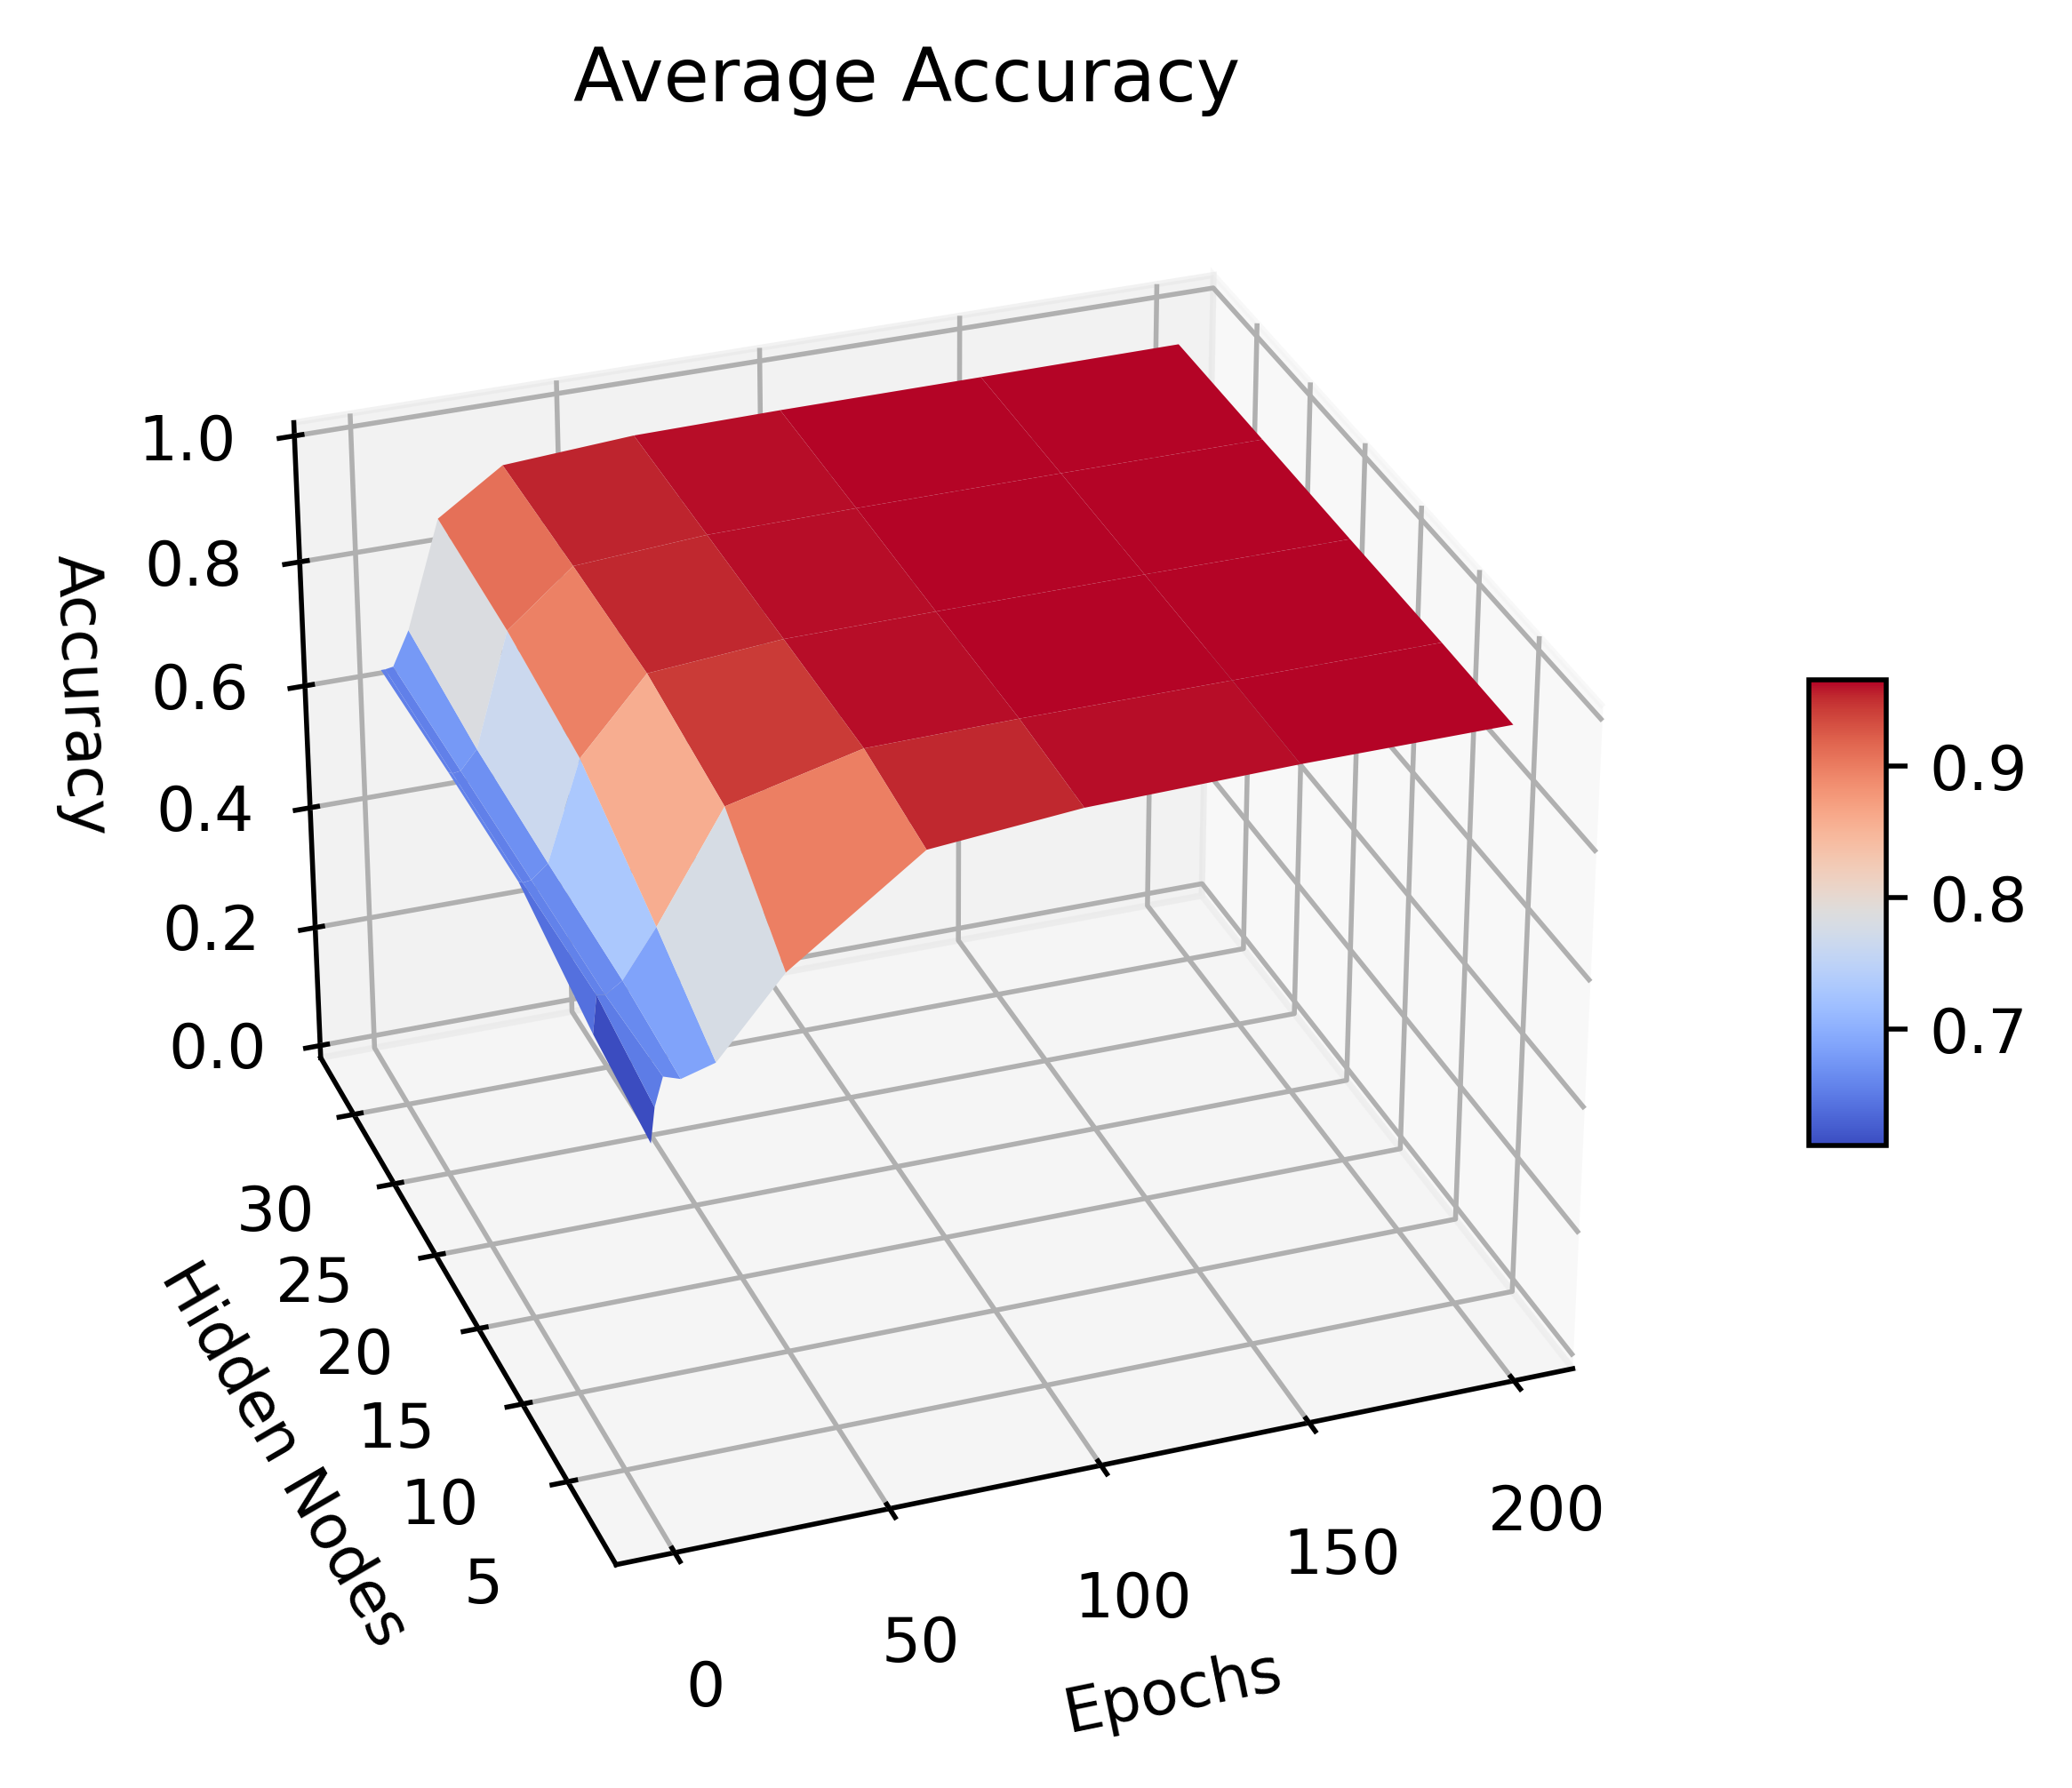

In [174]:
X, Y = np.meshgrid(multi_param_epochs, multi_param_nodes)

# fig = plt.figure(figsize=(10, 5))
fig = plt.figure()
fig.set_dpi(fig_dpi)
ax = plt.axes(projection='3d')

surf = ax.plot_surface(X, Y, mean_param_accuracy[0, :, :], cmap='coolwarm')
ax.set_title(f'Average Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Hidden Nodes')
ax.set_zlabel('Accuracy')
ax.view_init(30, -110)
ax.set_zlim([0, 1])
fig.colorbar(surf, shrink=0.3, aspect=6)

plt.tight_layout()
plt.savefig(f'graphs/{exp1_testname}-acc-surf.png')
plt.show()

### Test Error Rate Curves

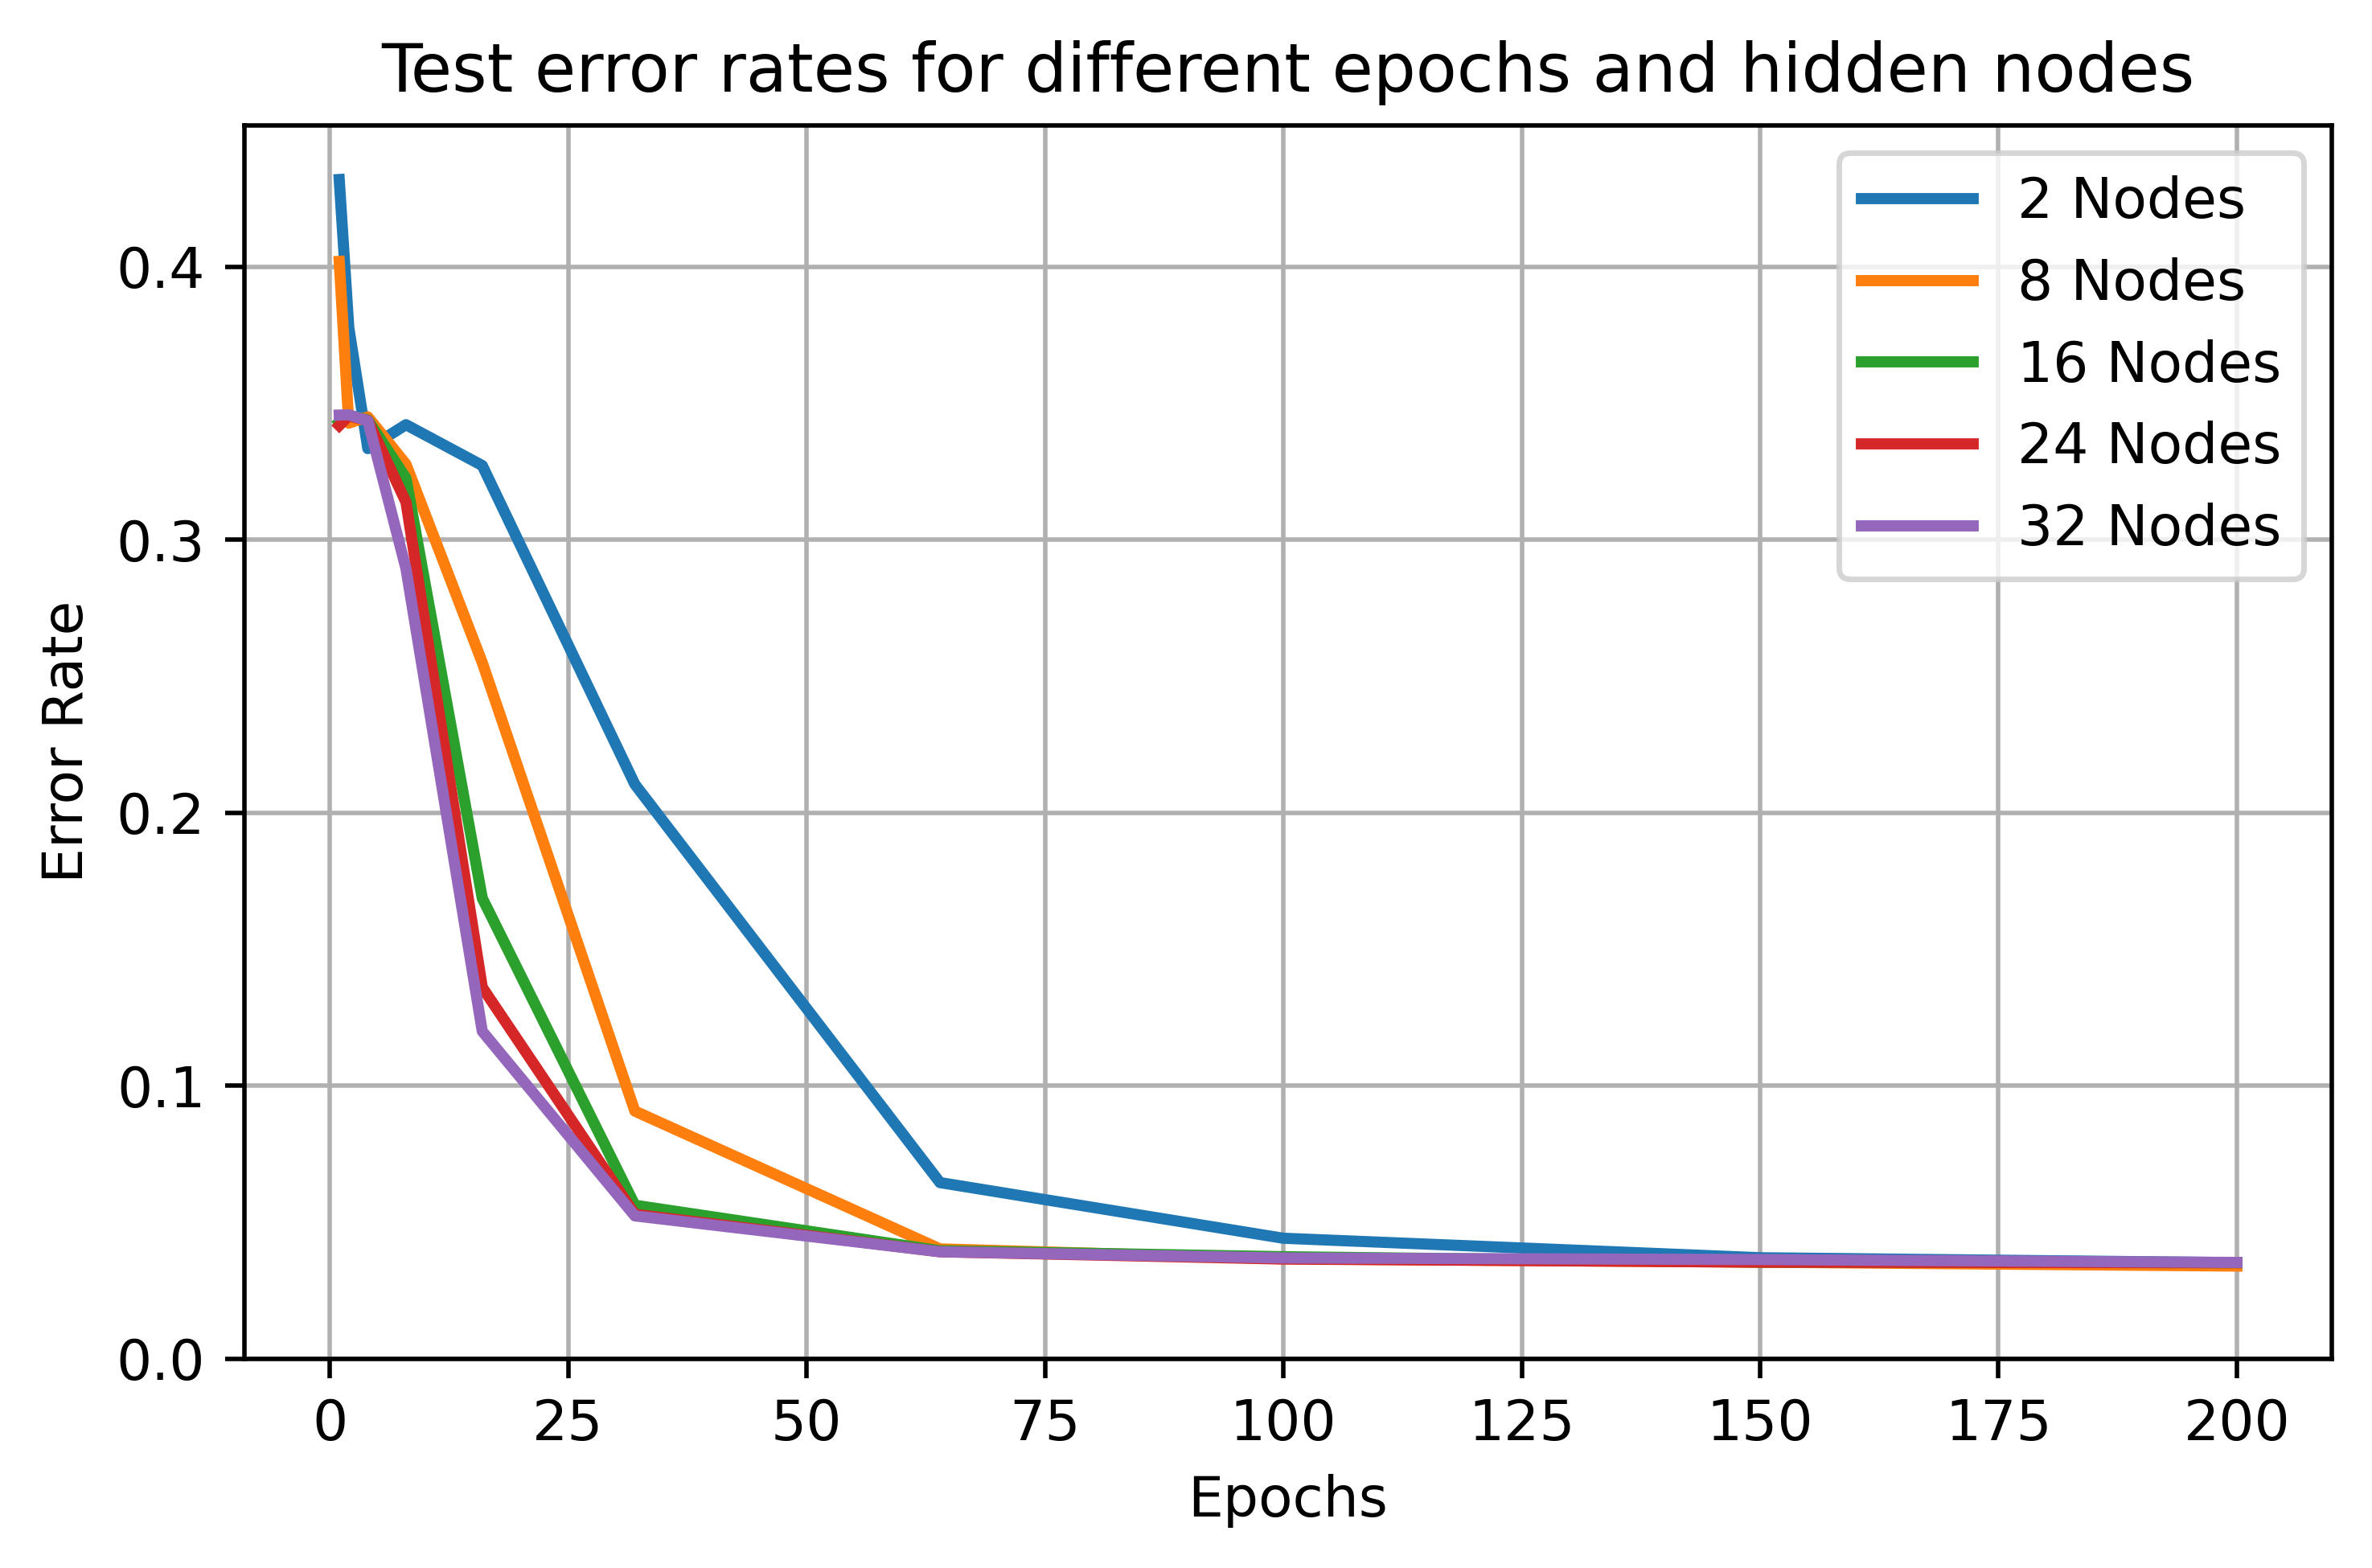

In [175]:
# fig = plt.figure(figsize=(7, 5))
fig = plt.figure()
fig.set_dpi(fig_dpi)

for idx, layer in enumerate(mean_param_accuracy[0, :, :]):
#     plt.errorbar(epochs, 1- layer, yerr=std_param_accuracy[idx], label=f'{hidden_nodes[idx]} Nodes')
    plt.plot(multi_param_epochs, 1 - layer, '-', label=f'{multi_param_nodes[idx]} Nodes', lw=2)

plt.legend()
plt.grid()
plt.title(f"Test error rates for different epochs and hidden nodes")
plt.xlabel("Epochs")
plt.ylabel("Error Rate")
plt.ylim(0)

plt.tight_layout()
plt.savefig(f'graphs/{exp1_testname}-error-rate-curves.png')
plt.show()

### Test/Train Error Over Nodes

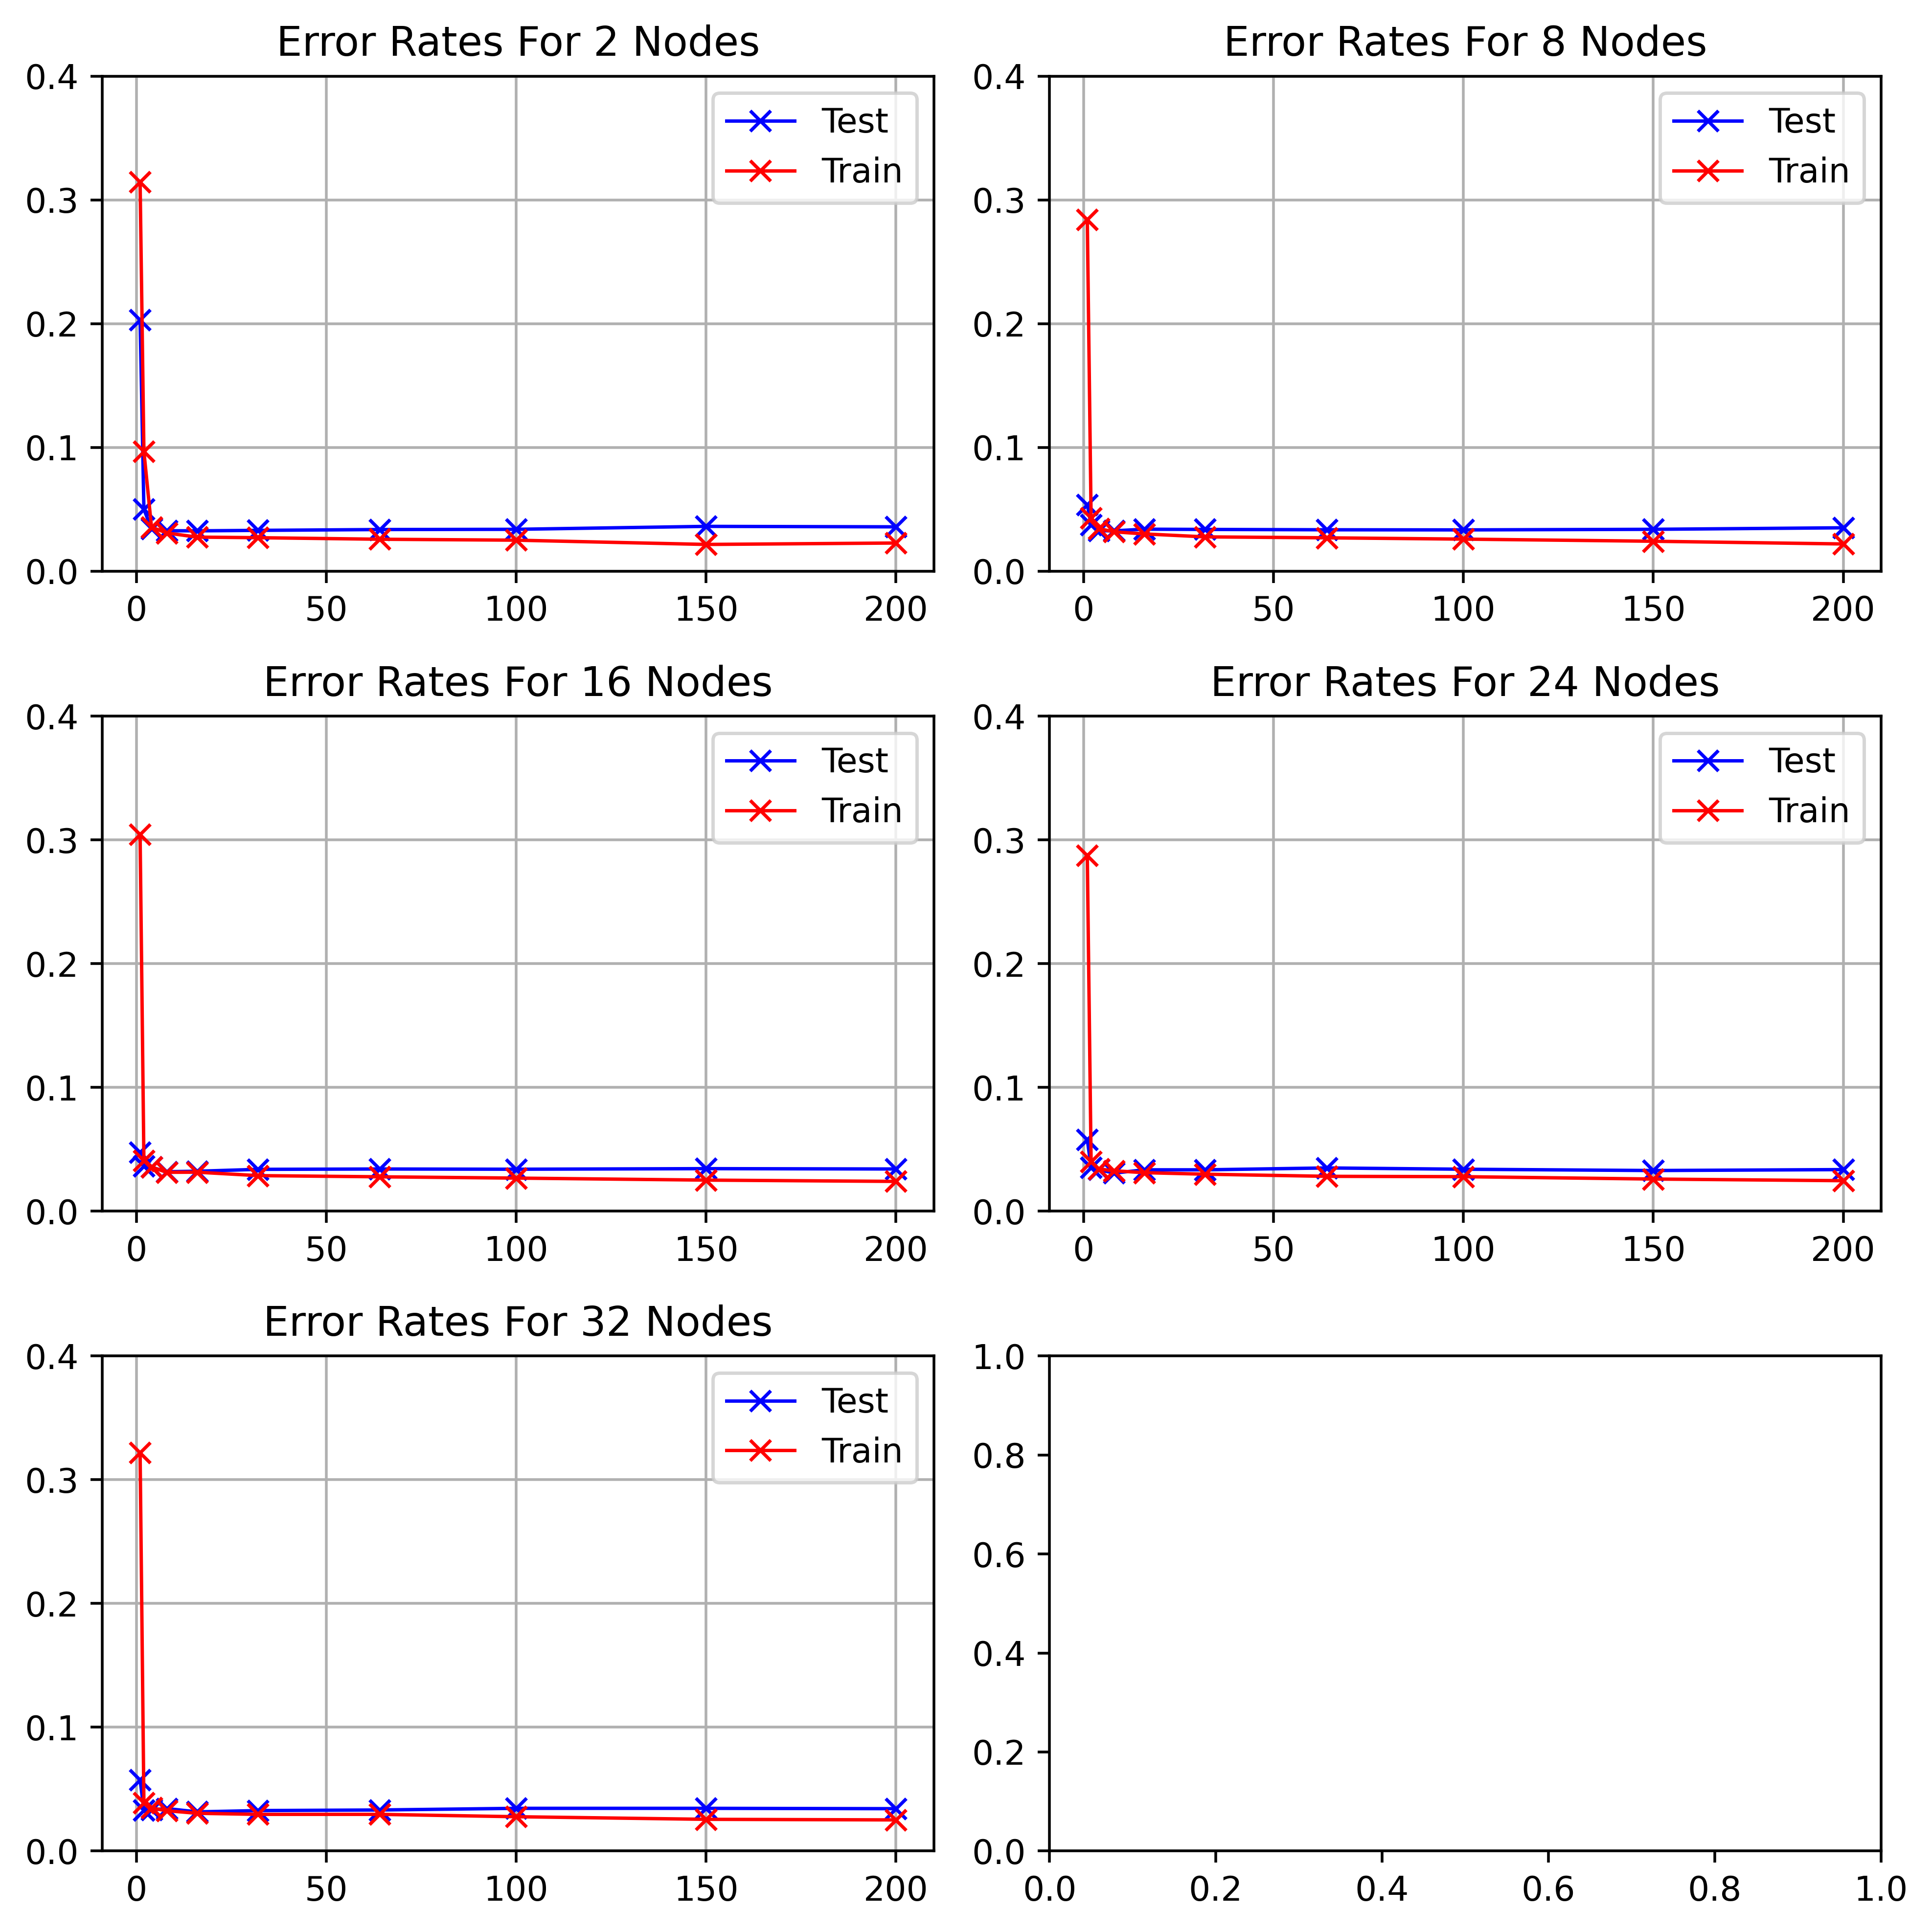

In [169]:
fig, axes = plt.subplots(math.ceil(len(multi_param_nodes) / 2), 2, figsize=(8, 8*math.ceil(len(multi_param_nodes) / 2)/3))
fig.set_dpi(fig_dpi)

for idx, (nodes, ax) in enumerate(zip(multi_param_nodes, axes.flatten())):
    ax.set_title(f'Error Rates For {nodes} Nodes')
#     ax.errorbar(multi_param_epochs, 1 - mean_param_accuracy[0, idx, :], fmt='x', ls='-', yerr=std_param_accuracy[0, idx, :], markersize=4, lw=1, label='Test', capsize=4, c=(0, 0, 1), ecolor=(0, 0, 1, 0.5))
#     ax.errorbar(multi_param_epochs, 1 - mean_param_accuracy[1, idx, :], fmt='x', ls='-', yerr=std_param_accuracy[1, idx, :], markersize=4, lw=1, label='Train', capsize=4, c=(1, 0, 0), ecolor=(1, 0, 0, 0.5))
    ax.plot(multi_param_epochs, 1 - mean_param_accuracy[0, idx, :], 'x', ls='-', lw=1, label='Test', c=(0, 0, 1))
    ax.plot(multi_param_epochs, 1 - mean_param_accuracy[1, idx, :], 'x', ls='-', lw=1, label='Train', c=(1, 0, 0))
    ax.set_ylim(0, np.round(np.max(1 - mean_param_accuracy + std_param_accuracy) + 0.05, 1))
    ax.legend()
    ax.grid()

fig.tight_layout()
fig.savefig(f'graphs/{exp1_testname}-test-train-error-rate.png')

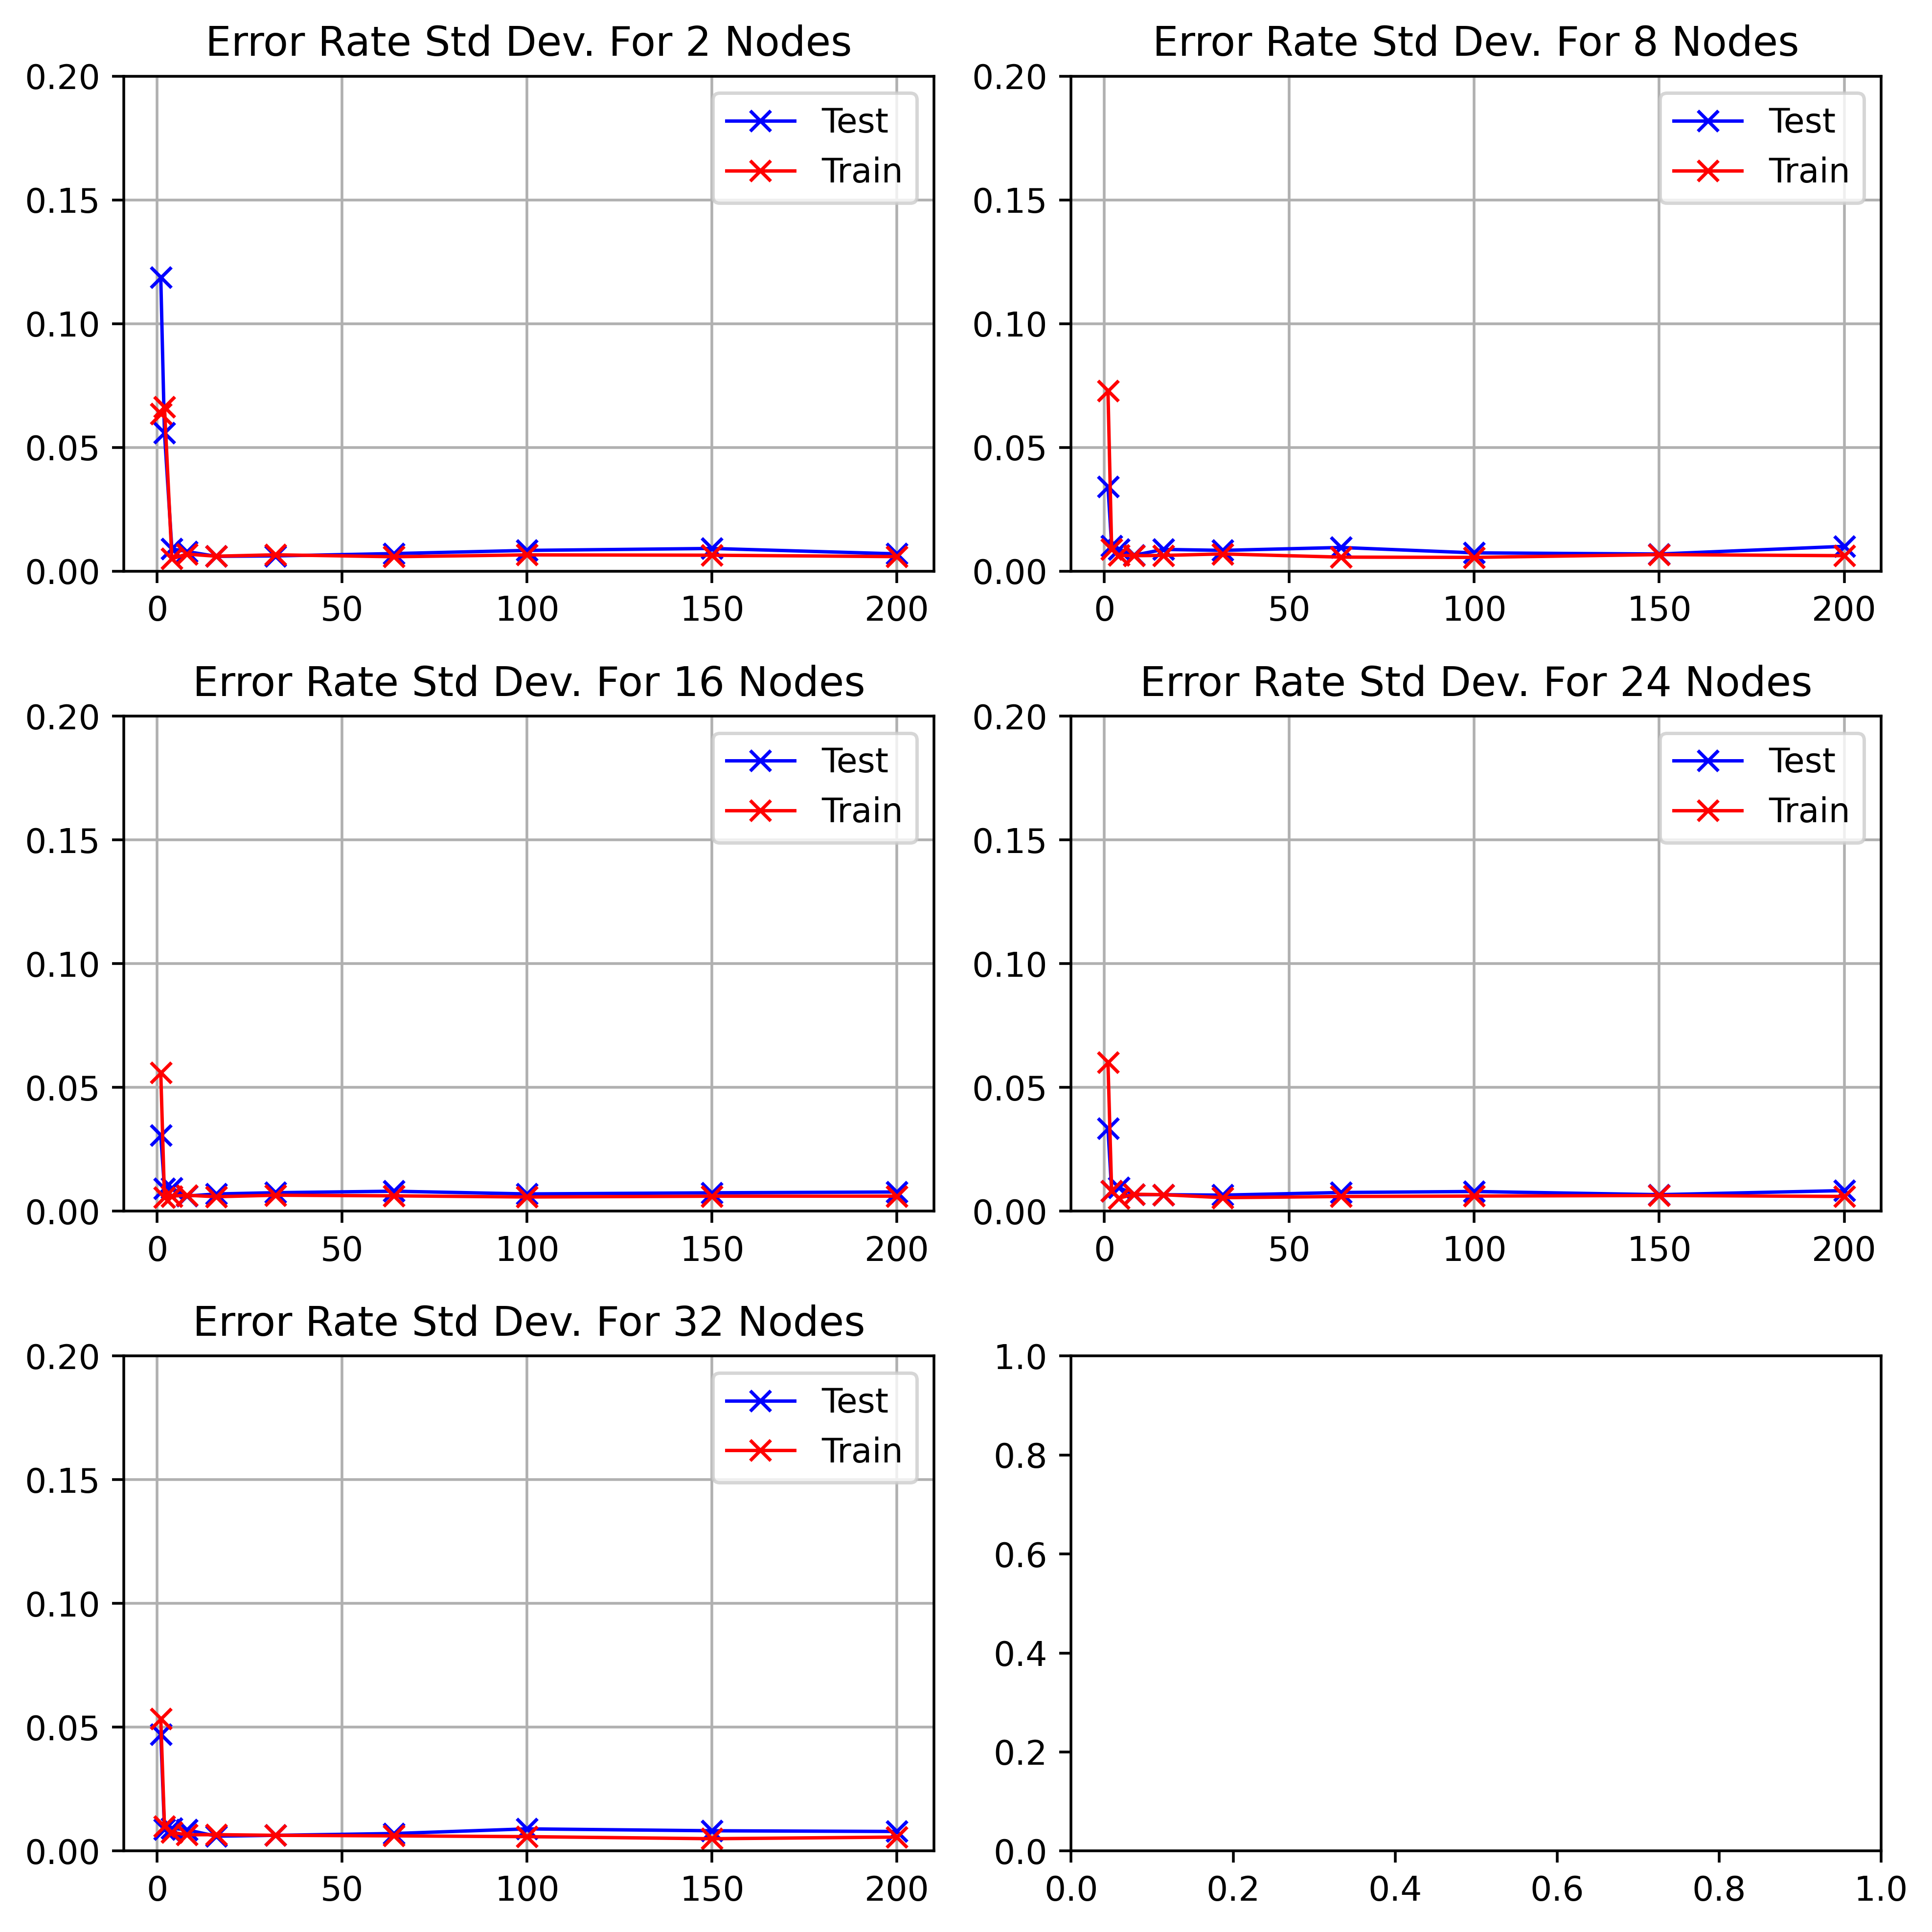

In [170]:
fig, axes = plt.subplots(math.ceil(len(multi_param_nodes) / 2), 2, figsize=(8, 8*math.ceil(len(multi_param_nodes) / 2)/3))
fig.set_dpi(fig_dpi)

for idx, (nodes, ax) in enumerate(zip(multi_param_nodes, axes.flatten())):
    ax.set_title(f'Error Rate Std Dev. For {nodes} Nodes')
    ax.plot(multi_param_epochs, std_param_accuracy[0, idx, :], 'x', ls='-', lw=1, label='Test', c=(0, 0, 1))
    ax.plot(multi_param_epochs, std_param_accuracy[1, idx, :], 'x', ls='-', lw=1, label='Train', c=(1, 0, 0))
    ax.set_ylim(0, np.round(np.max(std_param_accuracy) + 0.05, 1))
    ax.legend()
    ax.grid()

fig.tight_layout()
fig.savefig(f'graphs/{exp1_testname}-test-train-error-rate-std.png')

# Experiment 2

For cancer dataset, choose an appropriate value of node and epochs, based on Exp 1) and use ensemble of individual (base) classifiers with random starting weights and Majority Vote to see if performance improves - repeat the majority vote ensemble at least thirty times with different 50/50 split and average and graph (Each classifier in the ensemble sees the same training patterns). Repeat for a different odd number (prevents tied vote) of individual classifiers between 3 and 25, and comment on the result of individualclassifier accuracy vs ensemble accuracy as number of base classifiers varies. Consider changing the number of nodes/epochs (both less complex and more complex) to see if you obtain better performance, and comment on the result with respect to why the optimal node/epoch combination may be different for an ensemble compared with the base classifier, as in Exp 1). 

(Hint4: to implement majority vote you need to determine the predicted class labels –probably easier to implement yourself rather than use the ensemble matlab functions)


In [37]:
num_models=[1, 3, 9, 15, 25]

def evaluate_ensemble_vote(hidden_nodes=16, 
                           epochs=50, 
                           batch_size=128,
                           optimizer=lambda: 'sgd',
                           weight_init=lambda: 'glorot_uniform',
                           loss=lambda: 'categorical_crossentropy',
                           metrics=['accuracy'],
                           callbacks=None,
                           validation_split=None,

                           nmodels=num_models,

                           verbose=0,
                           print_params=True,
                           return_model=True,

                           dtrain=data_train,
                           dtest=data_test,
                           ltrain=labels_train,
                           ltest=labels_test):
    for m in nmodels:
        if print_params:
            print(f"Models: {m}")

        models = [get_model(hidden_nodes, weight_init=weight_init) for _ in range(m)]
        for model in models:        
            model.compile(
                optimizer=optimizer(),
                loss=loss(),
                metrics=metrics
                )
            
        

        response = {"nodes": hidden_nodes, 
                    "epochs": list(),
                    "num_models": m}
        
        histories = list()
        for idx, model in enumerate(models):
            if isinstance(epochs, tuple):
                e = np.linspace(epochs[0], epochs[1], num=len(models))[idx]
                e = int(e)
            else:
                e = epochs
            history = model.fit(dtrain, 
                                ltrain, 
                                epochs=e, 
                                verbose=verbose,

                                callbacks=callbacks,
                                validation_split=validation_split)
            histories.append(history.history)
            response["epochs"].append(e)

        response["history"] = histories        
        response["predictions"] = [model(dtest.to_numpy()) for model in models]
        response["optimizer"] = model.optimizer.get_config()
        response["model_config"] = json.loads(model.to_json())
        response["loss"] = model.loss

        ensem_sum = sum(tf.math.round(pred) for pred in response["predictions"])
        
        ltest_tensor = tf.constant(ltest.to_numpy())
        correct = 0
        for es, lt in zip(ensem_sum, ltest_tensor):
            if tf.math.argmax(es) == tf.math.argmax(lt):
                correct += 1
                
        response["accuracy"] = correct / len(ltest)

        if return_model:
            response["models"] = models

        yield response

## Single Iteration
Run a single iteration of ensemble model investigations

In [38]:
single_ensem_results = list()
for test in evaluate_ensemble_vote(epochs=(1, 100), optimizer=lambda: tf.keras.optimizers.SGD(learning_rate=0.02)):
    single_ensem_results.append(test)

Models: 1
Models: 3
Models: 9
Models: 15
Models: 25


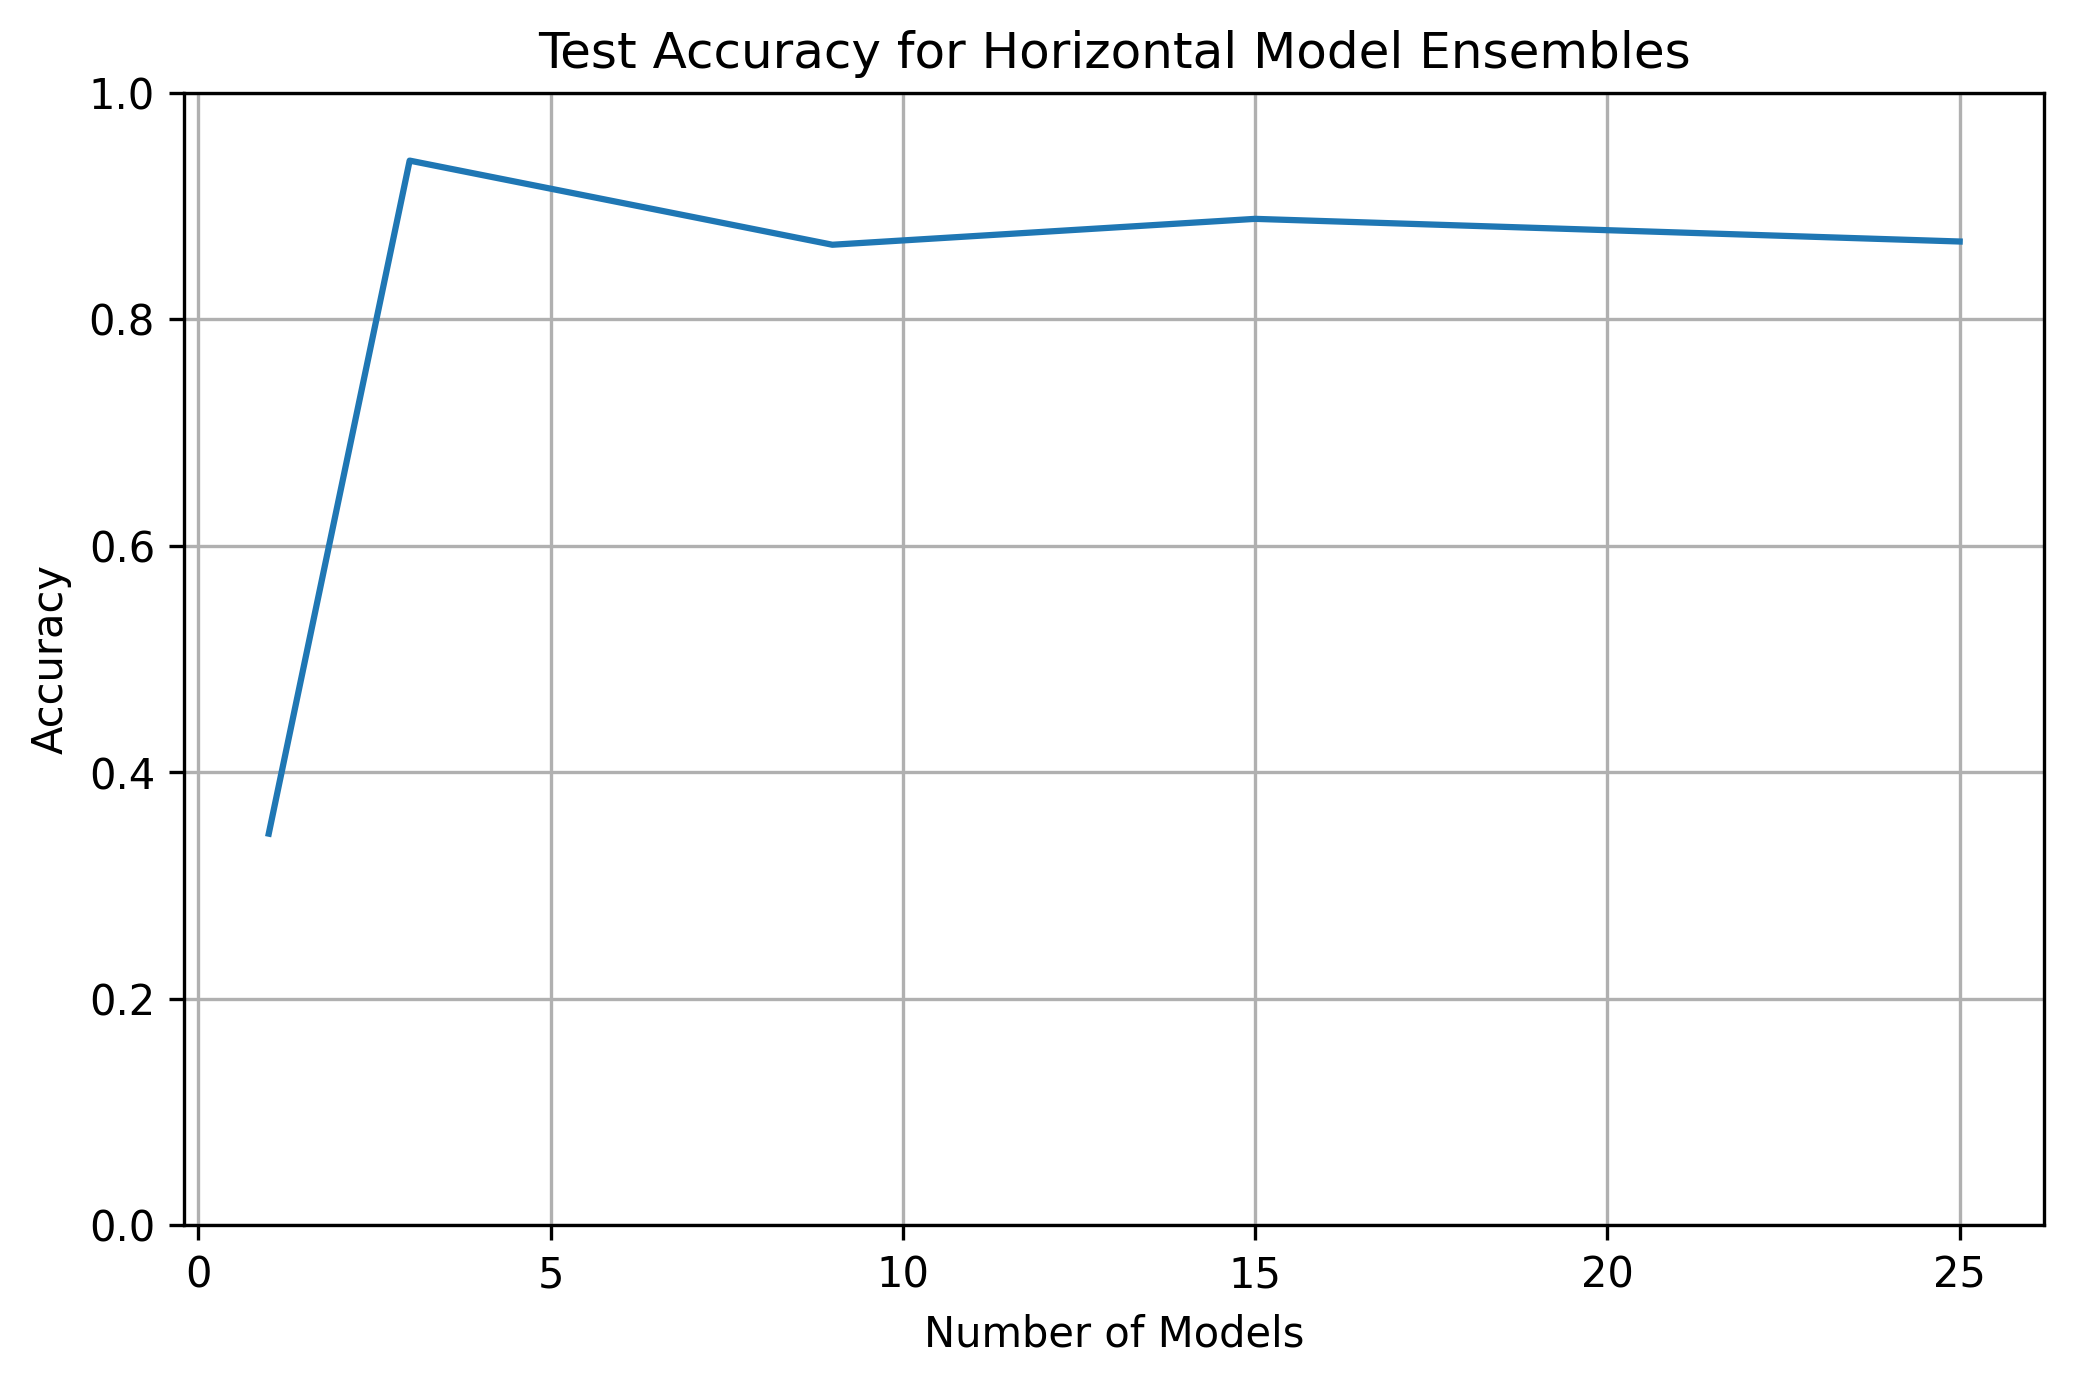

In [40]:
fig = plt.figure(figsize=(8, 5))
fig.set_dpi(fig_dpi)

plt.plot([i["num_models"] for i in single_ensem_results], [i["accuracy"] for i in single_ensem_results])
plt.title("Test Accuracy for Horizontal Model Ensembles")
plt.ylim(0, 1)
plt.grid()
plt.ylabel("Accuracy")
plt.xlabel("Number of Models")
plt.show()

## Multiple Iterations
Run multiple iterations of the ensemble model investigations and average

## CSV Results

| test | learning rate | momentum | batch size | hidden nodes | epochs | models |
| --- | --- | --- | --- | --- | --- | --- |
|1|0.06|0|128|16|50|1, 3, 9, 15, 25|
|2|0.06|0|35|16|1 - 100|1, 3, 9, 15, 25|

## Pickle Results

| test | learning rate | momentum | batch size | hidden nodes | epochs | models |
| --- | --- | --- | --- | --- | --- | --- |
|3|0.06|0.05|35|16|1 - 300|1, 3, 9, 15, 25|

In [46]:
multi_ensem_results = list()
multi_ensem_iterations = 30
for i in range(multi_ensem_iterations):
    print(f"Iteration {i+1}/{multi_ensem_iterations}")
    data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.5, stratify=labels)
    multi_ensem_results.append(list(evaluate_ensemble_vote(epochs=(1, 300),
                                                           weight_init=lambda: 'random_uniform',
                                                           batch_size=35,
                                                           dtrain=data_train, 
                                                           dtest=data_test, 
                                                           ltrain=labels_train, 
                                                           ltest=labels_test,
                                                           optimizer=lambda: tf.keras.optimizers.SGD(learning_rate=0.06, momentum=0.05),
                                                           return_model=False,
                                                           print_params=False)))

Iteration 1/30
Iteration 2/30
Iteration 3/30
Iteration 4/30
Iteration 5/30
Iteration 6/30
Iteration 7/30
Iteration 8/30
Iteration 9/30
Iteration 10/30
Iteration 11/30
Iteration 12/30
Iteration 13/30
Iteration 14/30
Iteration 15/30
Iteration 16/30
Iteration 17/30
Iteration 18/30
Iteration 19/30
Iteration 20/30
Iteration 21/30
Iteration 22/30
Iteration 23/30
Iteration 24/30
Iteration 25/30
Iteration 26/30
Iteration 27/30
Iteration 28/30
Iteration 29/30
Iteration 30/30


### Accuracy Tensor

Create a tensor for holding the accuracy results

(Iterations x [Test/Train] x Number of models)

In [48]:
multi_ensem_models = sorted(list({i["num_models"] for i in multi_ensem_results[0]}))
multi_ensem_iter = len(multi_ensem_results)

accuracy_ensem_tensor = np.zeros((multi_ensem_iter, 2, len(multi_ensem_models)))
for iter_idx, iteration in enumerate(multi_ensem_results):
    for single_test in iteration:
        accuracy_ensem_tensor[iter_idx, 0, multi_ensem_models.index(single_test['num_models'])] = single_test["accuracy"]
        
        accuracy_ensem_tensor[iter_idx, 1, multi_ensem_models.index(single_test['num_models'])] = np.mean([i["accuracy"][-1] for i in single_test["history"]])
        
mean_ensem_accuracy = np.mean(accuracy_ensem_tensor, axis=0)
std_ensem_accuracy = np.std(accuracy_ensem_tensor, axis=0)

print(f'{multi_ensem_iter} Tests')
print(f'Models: {multi_ensem_models}')
print()
print(f'Loss: {multi_param_results[0][0]["loss"]}')
print(f'LR: {multi_param_results[0][0]["optimizer"]["learning_rate"]}')
print(f'Momentum: {multi_param_results[0][0]["optimizer"]["momentum"]}')

#### Export/Import Test Sets

Export mean and standard deviations for retrieval and visualisation 

In [47]:
pickle.dump(multi_ensem_results, open("result.p", "wb"))

### Best Results

In [49]:
best_ensem_accuracy_idx = np.unravel_index(np.argmax(mean_ensem_accuracy[0, :]), mean_ensem_accuracy.shape)
best_ensem_accuracy = mean_ensem_accuracy[best_ensem_accuracy_idx]
best_ensem_accuracy_models = multi_ensem_models[best_ensem_accuracy_idx[1]]

print(f'Models: {best_ensem_accuracy_models}, {np.round(best_ensem_accuracy * 100, 1)}% Accurate')

Models: 9, 96.5% Accurate


### Test Accuracy Over Model Numbers

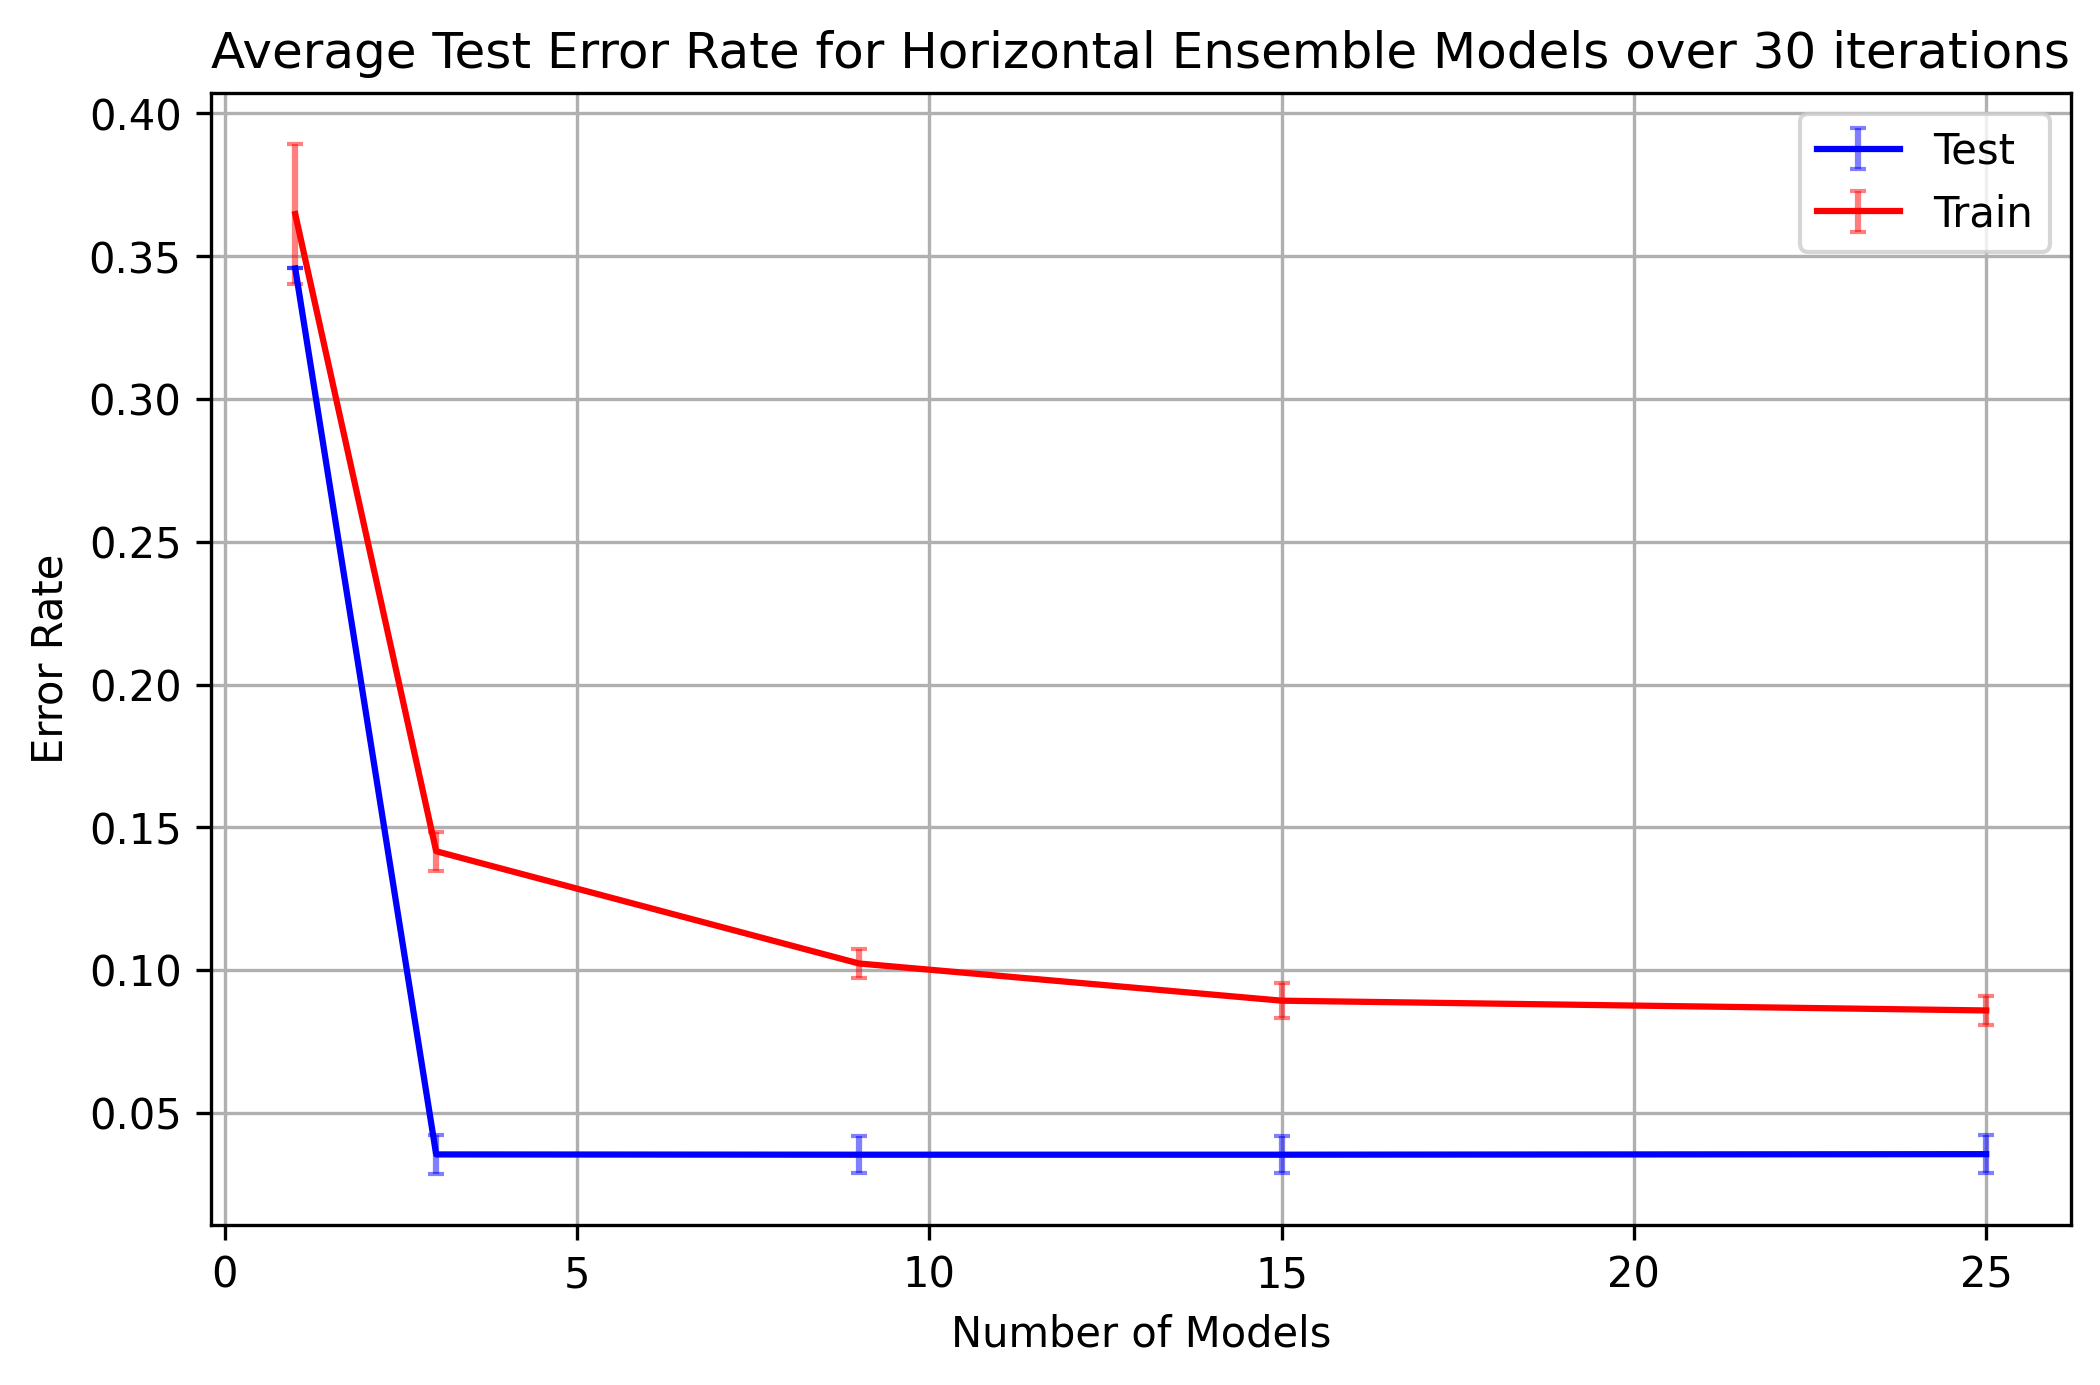

In [56]:
fig = plt.figure(figsize=(8, 5))
fig.set_dpi(fig_dpi)

plt.errorbar(multi_ensem_models, 1 - mean_ensem_accuracy[0, :], yerr=std_ensem_accuracy[0, :], capsize=2, label='Test', c=(0, 0, 1), ecolor=(0, 0, 1, 0.5))
plt.errorbar(multi_ensem_models, 1 - mean_ensem_accuracy[1, :], yerr=std_ensem_accuracy[1, :], capsize=2, label='Train', c=(1, 0, 0), ecolor=(1, 0, 0, 0.5))

plt.title(f"Average Test Error Rate for Horizontal Ensemble Models over {multi_ensem_iter} iterations")
# plt.ylim(0, 1)
plt.grid()
plt.legend()
plt.xlabel("Number of Models")
plt.ylabel("Error Rate")
plt.show()

# Experiment 3

Repeat Exp 2) for cancer dataset with two different optimisers of your choice e.g. ‘trainlm’ and ‘trainrp’. Comment and discuss the result and decide which is more appropriate training algorithm for the problem. In your discussion, include in your description a detailed account of how the training algorithms (optimisations) work.